In [1]:
## Important Options:
run_epochs = 200
run_model_type = "VAE"

run_save_folder = "../../outputs/experiments_test/syntheticshapes/vae_l2/" 
run_read_data_folder = "../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/" # 1 2 3
trust_set_name = "50_samples_per_class" # 5; 10; 25, 50;


In [3]:
%run ../repair_syserr_models/main.py \
    --cuda-on \
    --save-on \
    --output-folder {run_save_folder} \
    --verbose-metrics-epoch \
    --model-type {run_model_type} \
    --number-epochs {run_epochs} \
    --dataset-folder {run_read_data_folder} \
    --use-binary-img \
    --kl-anneal \
    --kl-anneal-start 0.0 \
    --kl-anneal-stop 1.0 \
    --kl-anneal-ratio 0.5 \
    --kl-anneal-delay-epochs 10 \
    --l2-reg 35.0 \
    --trust-set-name {trust_set_name}


Namespace(activation='relu', batch_size=128, cuda_on=True, data_folder='../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/', dist_corr_reg=False, dist_corr_reg_coeff=1.0, embedding_size=50, fixed_prior_z_clean=1.0, fixed_prior_z_dirty=5.0, fixed_prior_zy0_sigma=5.0, fixed_prior_zy1_sigma=1.0, kl_anneal=True, kl_anneal_cycles=1, kl_anneal_delay_epochs=10, kl_anneal_ratio=0.5, kl_anneal_start=0.0, kl_anneal_stop=1.0, kl_beta_const=1.0, l2_reg=35.0, latent_dim=15, layer_size=400, learn_z_given_y_priors=False, load_model=False, load_model_path=None, log_interval=50, lr=0.001, mean_eps_z_in=0.0, model_type='VAE', number_epochs=200, output_folder='../../outputs/experiments_test/syntheticshapes/vae_l2/', q_y_x_coeff=1.0, qy_sup_weights=None, reg_delay_n_epochs=5, reg_schedule_ratio=0.5, save_on=True, semi_supervise=False, sigma_eps_z_in=0.1, size_input=784, size_output=784, sup_loss_coeff=0.1, train_on_clean_data=False, trust_set_name='50_samples_per_class', use_batch_norm=F

In [4]:
ls ../../outputs/experiments_test/syntheticshapes/

cvae/  vae_l2/


### Define Paths

In [5]:
# Data folder
file_path_data = run_read_data_folder + "train/"

# Experiment / results folder
model_type = run_model_type
file_path_exper = run_save_folder + model_type + "/"

In [6]:
# Check folder of dataset
!ls {file_path_data}/..

cols_info.json	full  noising_info.json  test  train  validation


In [7]:
with open(file_path_data + "/y_noise_dict.json") as json_file:
    y_noise_dict_train = json.load(json_file)

#trusted_idxs_train = pd.read_csv(file_path_data + "/trusted_idxs.csv").values.flatten()
trusted_idxs_train = pd.read_csv(file_path_data + f"/trusted_idxs_{trust_set_name}.csv").values.flatten()

In [8]:
ls "../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/train/"

cells_changed_mtx.csv                  trusted_idxs_25_samples_per_class.csv
changes_summary.csv                    trusted_idxs_50_samples_per_class.csv
data_clean.csv                         trusted_idxs_5_samples_per_class.csv
data_noised.csv                        tuples_changed_mtx.csv
original_idxs.csv                      y_class.csv
trusted_idxs_10_samples_per_class.csv  y_noise_dict.json


### Check VARS on Notebook

In [9]:
whos

Variable               Type             Data/Info
-------------------------------------------------
StandardTrainer        type             <class 'repair_syserr_mod<...>r_utils.StandardTrainer'>
args                   Namespace        Namespace(activation='rel<...>False, y_clean_prior=0.7)
compute_metrics        function         <function compute_metrics at 0x7f6910208c10>
dict_main_vars         dict             n=53
errno                  module           <module 'errno' (built-in)>
evaluation_phase       function         <function evaluation_phase at 0x7f67c5962820>
file_path_data         str              ../../data/examples_synth<...>l_35_percent/run_1/train/
file_path_exper        str              ../../outputs/experiments<...>ntheticshapes/vae_l2/VAE/
frange_cycle_linear    function         <function frange_cycle_linear at 0x7f67c80f3dc0>
gen_utils              module           <module 'repair_syserr_mo<...>err_models/gen_utils.py'>
json                   module           <module

In [10]:
# debug vars -- from main.py
dict_main_vars.keys()

dict_keys(['args', 'train_loader', 'X_train', 'target_errors_train', 'dataset_obj', 'attributes', 'trusted_mask', 'train_loader_no_shuff', 'valid_loader', 'X_valid', 'target_errors_valid', 'dataset_valid_obj', '_', 'valid_loader_no_shuff', 'test_loader', 'X_test', 'target_errors_test', 'dataset_test_obj', 'test_loader_no_shuff', 'train_clean_loader', 'X_train_clean', 'dataset_obj_train_clean', 'train_clean_loader_no_shuff', 'X_valid_clean', 'dataset_obj_valid_clean', 'valid_clean_loader_no_shuff', 'X_test_clean', 'dataset_obj_test_clean', 'test_clean_loader_no_shuff', 'runin_model', 'model', 'train_optim', 'losses_save', 'kl_anneal', 'kl_beta_n_cycles', 'kl_beta_ratio', 'delay_n_epochs', 'delay_beta_vec', '_delay_n_epochs', 'kl_beta_vec', 'reg_schedule_vec', '_train_loader_used', '_train_loader_no_shuff', '_valid_loader_no_shuff', '_test_loader_no_shuff', '_X_train', '_X_valid', '_X_test', 'epoch', 'kl_beta_val', 'reg_schedule_val', 'folder_output', 'outfile'])

### Load Packages 

In [11]:
import pandas as pd
import numpy as np
import torch
import repair_syserr_models.gen_utils as gen_utils
from repair_syserr_models import VAE
import json

import pprint
import seaborn as sns
from matplotlib import pyplot as plt
import os
import json

### Check Dataset Definitions and Noising

In [12]:
with open(file_path_data + "../noising_info.json") as f:
    dt_defs = json.load(f)
pprint.pprint(dt_defs)

{'name': 'run_1',
 'synth_data': {'defs': {'combs_on': False,
                         'corrupt_prob': 0.35,
                         'n_samples': 5000,
                         'random_state': None},
                'noise_list_trusted': 'regular',
                'type': 'ShapesWithStrips'},
 'test_size': 0.1,
 'train_size': 0.8,
 'trusted_set': {'dataset_size': 5000,
                 'frac_trusted': None,
                 'mc_mode': 'fixed_number',
                 'min_coverage': True,
                 'n_classes': 8,
                 'percentages': [0.8, 1.6, 4.0, 8.0],
                 'samples_fixed': [5, 10, 25, 50],
                 'total_points': [40, 80, 200, 400],
                 'use_labels': 'joint_classes',
                 'y_class_on': True,
                 'y_noise_lists_on': True},
 'valid_size': 0.1}


In [13]:
with open(file_path_data + "../cols_info.json") as f:
    col_defs = json.load(f)
pprint.pprint(col_defs)

{'cat_cols_names': [],
 'dataset_type': 'image',
 'image_defs': {'channel_type': 'gray',
                'channels': [],
                'num_channels': 1,
                'size': [28, 28]},
 'num_cols_names': ['pixel_0',
                    'pixel_1',
                    'pixel_2',
                    'pixel_3',
                    'pixel_4',
                    'pixel_5',
                    'pixel_6',
                    'pixel_7',
                    'pixel_8',
                    'pixel_9',
                    'pixel_10',
                    'pixel_11',
                    'pixel_12',
                    'pixel_13',
                    'pixel_14',
                    'pixel_15',
                    'pixel_16',
                    'pixel_17',
                    'pixel_18',
                    'pixel_19',
                    'pixel_20',
                    'pixel_21',
                    'pixel_22',
                    'pixel_23',
                    'pixel_24',
                   

### Load Datasets

In [14]:

# train
train_loader, X_train, target_errors_train, dataset_obj, attributes, trusted_mask = gen_utils.load_data(args.data_folder, 
                                                                                                        args.batch_size,
                                                                                                        is_train=True,
                                                                                                        get_data_idxs=True,
                                                                                                        semi_sup_data=True,
                                                                                                        use_binary_img=False,
                                                                                                        trust_set_name=trust_set_name)
    

# Dynamic options for dataset_obj (from args)
dataset_obj.use_binary_img = args.use_binary_img


# test
test_loader, X_test, target_errors_test, _, _ = gen_utils.load_data(args.data_folder, 
                                                                    args.batch_size, 
                                                                    is_train=False,
                                                                    use_binary_img=False)

# -> clean versions for evaluation
_, X_train_clean, _, _, _ = gen_utils.load_data(args.data_folder, 
                                                args.batch_size,
                                                is_train=True, 
                                                is_clean=True, 
                                                stdize_dirty=True,
                                                use_binary_img=False)

_, X_test_clean, _, _, _ = gen_utils.load_data(args.data_folder, 
                                               args.batch_size, 
                                               is_train=False,
                                               is_clean=True, 
                                               stdize_dirty=True,
                                               use_binary_img=False)


In [15]:
args.data_folder

'../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/'

In [16]:
y_noise_instance_train = target_errors_train.any(dim=1).numpy()
y_noise_pixels_train = target_errors_train.numpy().reshape(-1,28,28)

y_targets_mdl = ~ torch.from_numpy(y_noise_instance_train).view(-1,1)

x_train_orig = X_train.view(-1,28,28).numpy()
x_train_clean_orig = X_train_clean.view(-1,28,28).numpy()


In [17]:
X_train_clean.view(-1,28,28)

tensor([[[-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473],
         [-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473],
         [-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473],
         ...,
         [-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473],
         [-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473],
         [-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473]],

        [[-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473],
         [-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473],
         [-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473],
         ...,
         [-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473],
         [-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473],
         [-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473]],

        [[-0.4473, -0.4473, -0.4473,  ..., -0.4473, -0.4473, -0.4473],
         [-0.4473, -0.4473, -0.4473,  ..., -0

### Load Model

In [18]:
vae_mdl = eval(model_type).VAE(dataset_obj, args)
file_path_model = file_path_exper + "model_params.pth"
vae_mdl.load_state_dict(torch.load(file_path_model))
vae_mdl.eval()

VAE(
  (activ): ReLU()
  (var_q_z): encodeMVNDiag(
    (torso_encoder): baseEncoder(
      (activ): ReLU()
      (feat_embedd): ModuleList()
      (mod_fw_seq): Sequential(
        (fc_0): Linear(in_features=784, out_features=200, bias=True)
        (activ_0): ReLU()
        (fc_1): Linear(in_features=200, out_features=100, bias=True)
        (activ_1): ReLU()
        (fc_2): Linear(in_features=100, out_features=50, bias=True)
        (activ_2): ReLU()
      )
    )
    (param_nn): GaussDiagDistModule(
      (mu): modSeq(
        (mods_list): ModuleList(
          (0): baseEncoder(
            (activ): ReLU()
            (feat_embedd): ModuleList()
            (mod_fw_seq): Sequential(
              (fc_0): Linear(in_features=784, out_features=200, bias=True)
              (activ_0): ReLU()
              (fc_1): Linear(in_features=200, out_features=100, bias=True)
              (activ_1): ReLU()
              (fc_2): Linear(in_features=100, out_features=50, bias=True)
              (ac

### Load Results from Folder

In [19]:
file_path_exper

'../../outputs/experiments_test/syntheticshapes/vae_l2/VAE/'

In [20]:
df_train_metrics = pd.read_csv(file_path_exper + "train_epochs_data.csv")
df_valid_metrics = pd.read_csv(file_path_exper + "validation_epochs_data.csv")
df_test_metrics = pd.read_csv(file_path_exper + "test_epochs_data.csv")

In [21]:
!ls {file_path_exper}

args_run.json			train_error_repair_features.csv
model_params.pth		trusted_auc_features.csv
test_auc_features.csv		trusted_avpr_features.csv
test_avpr_features.csv		trusted_epochs_data.csv
test_epochs_data.csv		trusted_error_repair_features.csv
test_error_repair_features.csv	validation_auc_features.csv
train_auc_features.csv		validation_avpr_features.csv
train_avpr_features.csv		validation_epochs_data.csv
train_epochs_data.csv		validation_error_repair_features.csv


In [22]:
df_train_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0         1       329.279342      329.279342            0.0  329.279342   
1         2       312.582710      312.582710            0.0  312.582710   
2         3       287.623115      287.623115            0.0  287.623115   
3         4       275.242773      275.242773            0.0  275.242773   
4         5       255.492117      255.492117            0.0  255.492117   
..      ...              ...             ...            ...         ...   
195     196        78.489412       78.489412            0.0   59.351961   
196     197        78.093128       78.093128            0.0   59.429914   
197     198        77.968193       77.968193            0.0   59.190424   
198     199        78.227121       78.227121            0.0   59.368584   
199     200        78.354193       78.354193            0.0   59.615598   

     Avg. KLD_TOT  Avg. KLD_Z  AUC Cell nll score  AVPR Cell nll score  \
0        0.535407    0.535407            0.835025             0.418963   
1        0.252730    0.252730            0.869383             0.455891   
2        3.935195    3.935195            0.854671             0.459582   
3        5.923797    5.923797            0.864374             0.467487   
4       29.280759   29.280759            0.877909             0.473178   
..            ...         ...                 ...                  ...   
195     19.137451   19.137451            0.993519             0.940737   
196     18.663213   18.663213            0.995076             0.952003   
197     18.777770   18.777770            0.994117             0.939034   
198     18.858537   18.858537            0.992699             0.932301   
199     18.738595   18.738595            0.992493             0.931465   

     AUC Row nll score  AVPR Row nll score  AUC Row class_y score  \
0             0.587794            0.408613                  -10.0   
1             0.616082            0.430518                  -10.0   
2             0.604977            0.421767                  -10.0   
3             0.606731            0.423588                  -10.0   
4             0.620242            0.432670                  -10.0   
..                 ...                 ...                    ...   
195           0.935335            0.863105                  -10.0   
196           0.935420            0.863329                  -10.0   
197           0.937481            0.868111                  -10.0   
198           0.938189            0.864530                  -10.0   
199           0.924903            0.847819                  -10.0   

     AVPR Row class_y score  Error lower-bound on dirty pos  \
0                     -10.0                        0.158258   
1                     -10.0                        0.148390   
2                     -10.0                        0.132407   
3                     -10.0                        0.126116   
4                     -10.0                        0.112356   
..                      ...                             ...   
195                   -10.0                        0.029727   
196                   -10.0                        0.028198   
197                   -10.0                        0.029591   
198                   -10.0                        0.032756   
199                   -10.0                        0.035651   

     Error upper-bound on dirty pos  Error repair on dirty pos  \
0                               1.0                   0.157001   
1                               1.0                   0.149052   
2                               1.0                   0.137479   
3                               1.0                   0.132168   
4                               1.0                   0.118930   
..                              ...                        ...   
195                             1.0                   0.045189   
196                             1.0                   0.042078   
197                             1.0

In [23]:
df_valid_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0         1       330.249234      330.249234            0.0  330.249234   
1         2       313.462320      313.462320            0.0  313.462320   
2         3       289.620789      289.620789            0.0  289.620789   
3         4       277.544328      277.544328            0.0  277.544328   
4         5       256.187039      256.187039            0.0  256.187039   
..      ...              ...             ...            ...         ...   
195     196        80.004029       80.004029            0.0   61.001274   
196     197        79.567666       79.567666            0.0   60.938832   
197     198        79.416822       79.416822            0.0   60.673393   
198     199        79.830713       79.830713            0.0   61.037347   
199     200        80.245480       80.245480            0.0   61.628954   

     Avg. KLD_TOT  Avg. KLD_Z  AUC Cell nll score  AVPR Cell nll score  \
0        0.523718    0.523718            0.836867             0.439328   
1        0.249793    0.249793            0.872976             0.481214   
2        3.825883    3.825883            0.854128             0.479727   
3        5.635370    5.635370            0.866873             0.485396   
4       27.753611   27.753611            0.884776             0.496071   
..            ...         ...                 ...                  ...   
195     19.002755   19.002755            0.993841             0.941958   
196     18.628835   18.628835            0.995006             0.949923   
197     18.743427   18.743427            0.993880             0.938123   
198     18.793365   18.793365            0.992633             0.933192   
199     18.616528   18.616528            0.992610             0.932536   

     AUC Row nll score  AVPR Row nll score  AUC Row class_y score  \
0             0.543066            0.380848                  -10.0   
1             0.579483            0.399301                  -10.0   
2             0.561301            0.390168                  -10.0   
3             0.566025            0.388044                  -10.0   
4             0.588520            0.405843                  -10.0   
..                 ...                 ...                    ...   
195           0.931729            0.857278                  -10.0   
196           0.924777            0.848281                  -10.0   
197           0.933636            0.858099                  -10.0   
198           0.932763            0.860242                  -10.0   
199           0.922103            0.843700                  -10.0   

     AVPR Row class_y score  Error lower-bound on dirty pos  \
0                     -10.0                        0.157935   
1                     -10.0                        0.147786   
2                     -10.0                        0.129435   
3                     -10.0                        0.123479   
4                     -10.0                        0.106423   
..                      ...                             ...   
195                   -10.0                        0.027536   
196                   -10.0                        0.027106   
197                   -10.0                        0.028443   
198                   -10.0                        0.031492   
199                   -10.0                        0.031764   

     Error upper-bound on dirty pos  Error repair on dirty pos  \
0                               1.0                   0.156694   
1                               1.0                   0.148428   
2                               1.0                   0.135089   
3                               1.0                   0.129995   
4                               1.0                   0.112582   
..                              ...                        ...   
195                             1.0                   0.042418   
196                             1.0                   0.040663   
197                             1.0

In [24]:
df_test_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0         1       330.249234      330.249234            0.0  330.249234   
1         2       313.462320      313.462320            0.0  313.462320   
2         3       289.620789      289.620789            0.0  289.620789   
3         4       277.544328      277.544328            0.0  277.544328   
4         5       256.187039      256.187039            0.0  256.187039   
..      ...              ...             ...            ...         ...   
195     196        80.004029       80.004029            0.0   61.001274   
196     197        79.567666       79.567666            0.0   60.938832   
197     198        79.416822       79.416822            0.0   60.673393   
198     199        79.830713       79.830713            0.0   61.037347   
199     200        80.245480       80.245480            0.0   61.628954   

     Avg. KLD_TOT  Avg. KLD_Z  AUC Cell nll score  AVPR Cell nll score  \
0        0.523718    0.523718            0.836867             0.439328   
1        0.249793    0.249793            0.872976             0.481214   
2        3.825883    3.825883            0.854128             0.479727   
3        5.635370    5.635370            0.866873             0.485396   
4       27.753611   27.753611            0.884776             0.496071   
..            ...         ...                 ...                  ...   
195     19.002755   19.002755            0.993841             0.941958   
196     18.628835   18.628835            0.995006             0.949923   
197     18.743427   18.743427            0.993880             0.938123   
198     18.793365   18.793365            0.992633             0.933192   
199     18.616528   18.616528            0.992610             0.932536   

     AUC Row nll score  AVPR Row nll score  AUC Row class_y score  \
0             0.543066            0.380848                  -10.0   
1             0.579483            0.399301                  -10.0   
2             0.561301            0.390168                  -10.0   
3             0.566025            0.388044                  -10.0   
4             0.588520            0.405843                  -10.0   
..                 ...                 ...                    ...   
195           0.931729            0.857278                  -10.0   
196           0.924777            0.848281                  -10.0   
197           0.933636            0.858099                  -10.0   
198           0.932763            0.860242                  -10.0   
199           0.922103            0.843700                  -10.0   

     AVPR Row class_y score  Error lower-bound on dirty pos  \
0                     -10.0                        0.157935   
1                     -10.0                        0.147786   
2                     -10.0                        0.129435   
3                     -10.0                        0.123479   
4                     -10.0                        0.106423   
..                      ...                             ...   
195                   -10.0                        0.027536   
196                   -10.0                        0.027106   
197                   -10.0                        0.028443   
198                   -10.0                        0.031492   
199                   -10.0                        0.031764   

     Error upper-bound on dirty pos  Error repair on dirty pos  \
0                               1.0                   0.156694   
1                               1.0                   0.148428   
2                               1.0                   0.135089   
3                               1.0                   0.129995   
4                               1.0                   0.112582   
..                              ...                        ...   
195                             1.0                   0.042418   
196                             1.0                   0.040663   
197                             1.0

In [25]:
n_epochs = df_train_metrics.shape[0]
epochs_range = list(range(1,n_epochs+1))

### Train Dataset Final Results

In [26]:
# Train final results
df_train_metrics.loc[n_epochs-1,:]

Epochs                                      200.000000
Avg. TOTAL_LOSS                              78.354193
Avg. LOSS_ELBO                               78.354193
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                     59.615598
Avg. KLD_TOT                                 18.738595
Avg. KLD_Z                                   18.738595
AUC Cell nll score                            0.992493
AVPR Cell nll score                           0.931465
AUC Row nll score                             0.924903
AVPR Row nll score                            0.847819
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.035651
Error upper-bound on dirty pos                1.000000
Error repair on dirty pos                     0.050830
Error repair on clean pos                     0.016526
Error repair on clean pos - dirty points      0.018014
Name: 199,

In [27]:
# Validation final results
df_valid_metrics.loc[n_epochs-1,:]

Epochs                                      200.000000
Avg. TOTAL_LOSS                              80.245480
Avg. LOSS_ELBO                               80.245480
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                     61.628954
Avg. KLD_TOT                                 18.616528
Avg. KLD_Z                                   18.616528
AUC Cell nll score                            0.992610
AVPR Cell nll score                           0.932536
AUC Row nll score                             0.922103
AVPR Row nll score                            0.843700
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.031764
Error upper-bound on dirty pos                1.000000
Error repair on dirty pos                     0.047076
Error repair on clean pos                     0.017549
Error repair on clean pos - dirty points      0.019085
Name: 199,

### Test Dataset Final Results

In [28]:
# Train final results
df_test_metrics.loc[n_epochs-1,:]

Epochs                                      200.000000
Avg. TOTAL_LOSS                              80.245480
Avg. LOSS_ELBO                               80.245480
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                     61.628954
Avg. KLD_TOT                                 18.616528
Avg. KLD_Z                                   18.616528
AUC Cell nll score                            0.992610
AVPR Cell nll score                           0.932536
AUC Row nll score                             0.922103
AVPR Row nll score                            0.843700
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.031764
Error upper-bound on dirty pos                1.000000
Error repair on dirty pos                     0.047076
Error repair on clean pos                     0.017549
Error repair on clean pos - dirty points      0.019085
Name: 199,

## PLOTS TRAIN DATASET

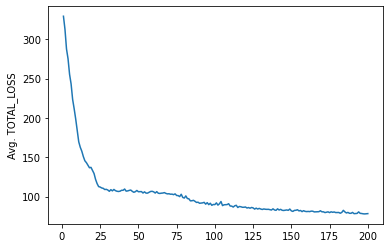

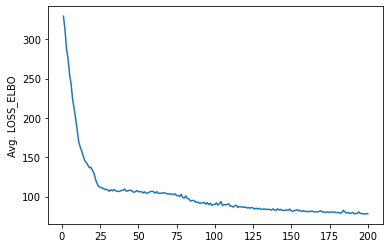

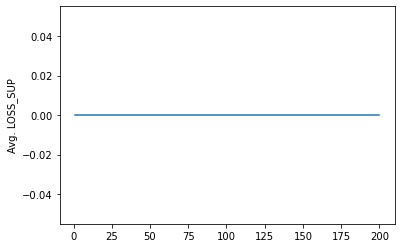

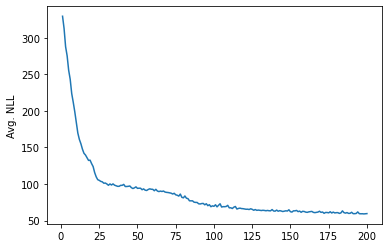

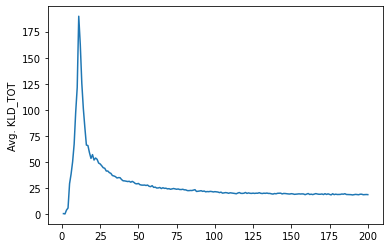

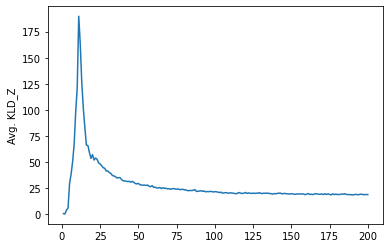

In [29]:
# Plots for losses
for col_name in df_train_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_train_metrics[col_name])
        plt.show()

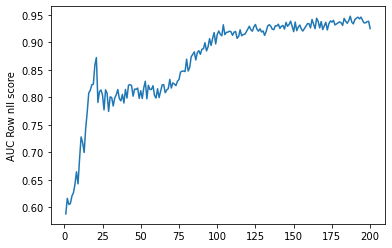

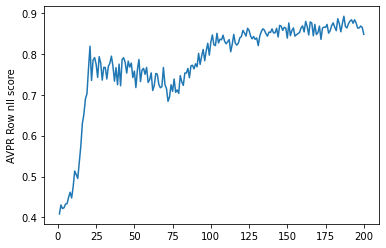

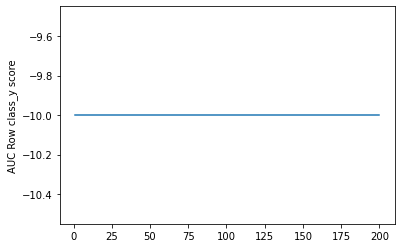

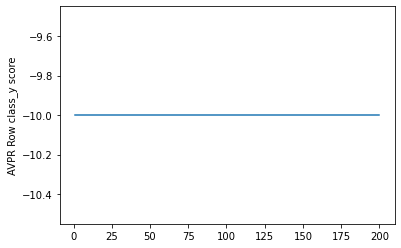

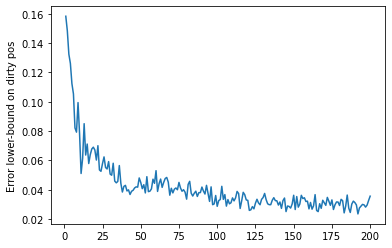

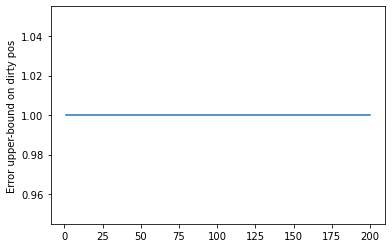

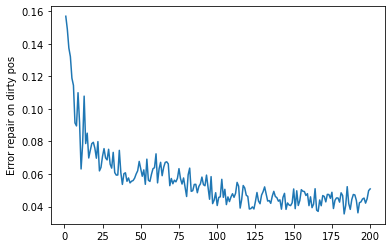

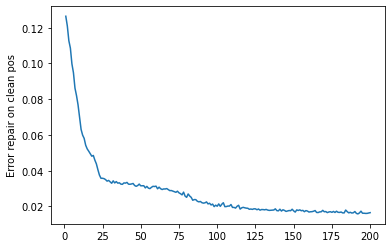

In [30]:
# Plots for classification and repair metrics
list_plot_custom = ["AUC Row nll score", "AVPR Row nll score", 
                    "AUC Row class_y score", "AVPR Row class_y score",
                    "Error lower-bound on dirty pos", "Error upper-bound on dirty pos",
                    "Error repair on dirty pos", "Error repair on clean pos"]

for col_name in list_plot_custom:
    sns.lineplot(x=epochs_range,y=df_train_metrics[col_name])
    plt.show()

### Plot Validation -- Losses

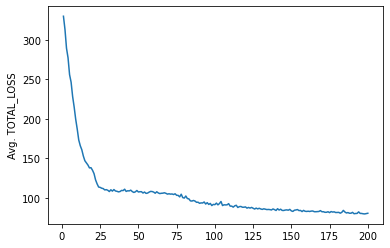

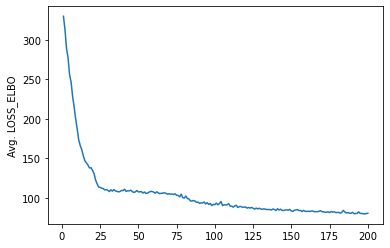

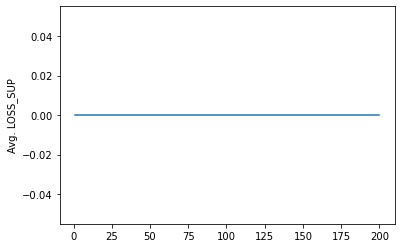

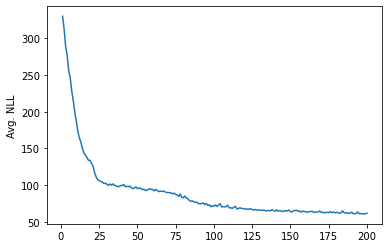

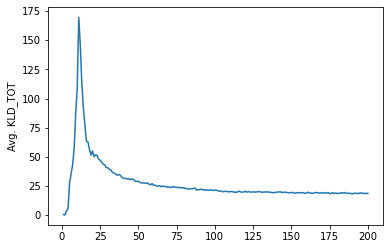

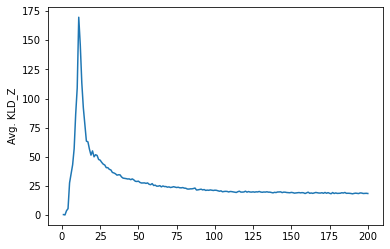

In [31]:
# Plots for losses
for col_name in df_valid_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_valid_metrics[col_name])
        plt.show()

### Plot Test -- Losses

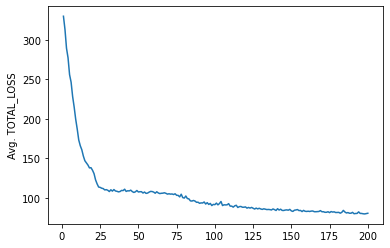

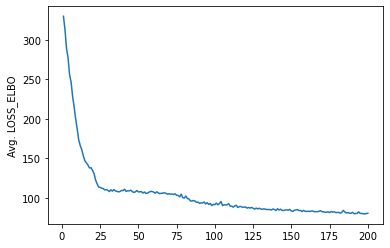

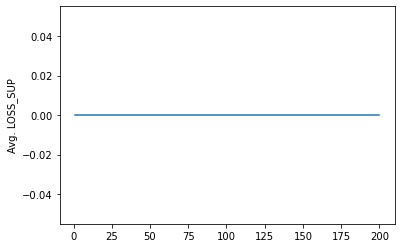

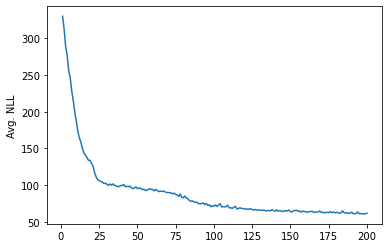

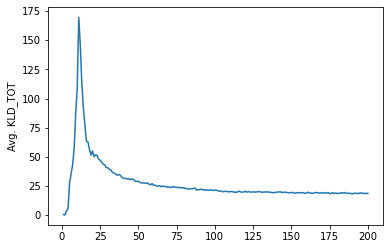

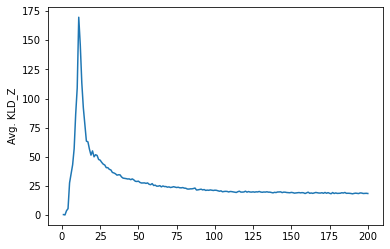

In [32]:
# Plots for losses
for col_name in df_test_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_test_metrics[col_name])
        plt.show()

### Get Recons, Latent Space, etc

In [33]:
vae_p_params_xd, vae_q_params, vae_q_samples, _ = vae_mdl(X_train)
recons_train = vae_p_params_xd['recon']['x'].cpu().detach().numpy()
z_train_clean = vae_q_params['z']['mu'].detach().cpu().numpy()


In [34]:
# Show mu and covariance values

z_train_mu = vae_q_params['z']['mu'].detach().cpu().numpy()
z_train_var = np.exp(vae_q_params['z']['logvar'].detach().cpu().numpy())

print("median of variances (per dim), clean: \n {} \n".format(np.median(z_train_var, axis=0)))
print("median of means (per dim), clean: \n {} \n".format(np.median(z_train_mu, axis=0)))


median of variances (per dim), clean: 
 [7.7100509e-01 7.0599699e-04 9.7290999e-01 9.7950572e-01 5.3306043e-01
 2.8370912e-03 2.8808823e-01 5.2034404e-05 1.9602197e-04 9.9823779e-01
 1.0009589e+00 9.9015570e-01 1.5269627e-04 9.9076355e-01 2.9634091e-05] 

median of means (per dim), clean: 
 [ 8.9578122e-01  3.0330567e+00  6.3944735e-02  1.7004060e-02
  1.3699039e+00  6.4006190e+00  2.1583514e+00  2.5085568e+00
  6.7577207e-01 -5.3806927e-02  3.4553416e-02 -1.8182326e-02
  3.1292093e+00  4.9097380e-03 -3.0172215e+00] 



### Recons

In [35]:
recon_imgs_train = recons_train.reshape(-1,28,28)

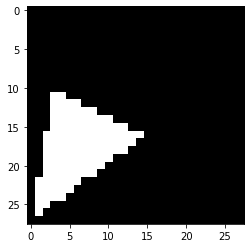

In [36]:
# Show image from train dataset

plt.imshow(x_train_orig[546], cmap="gray",)

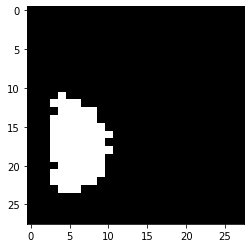

In [37]:
# Show image reconstruction from VAE model

plt.imshow(np.around(recon_imgs_train[546]), cmap="gray", )

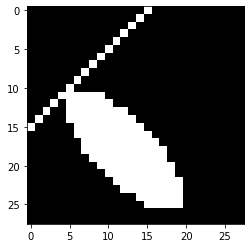

In [38]:
# Show image from train dataset

plt.imshow(x_train_orig[540], cmap="gray",)

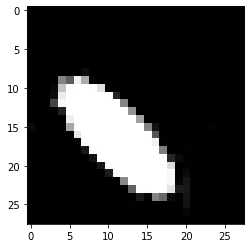

In [39]:
# Show image reconstruction from VAE model

plt.imshow(recon_imgs_train[540], cmap="gray",)

### Show Clean Datapoints at Random

y_noise: 0


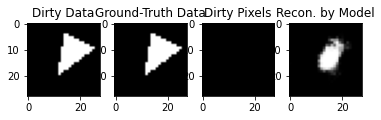

y_noise: 0


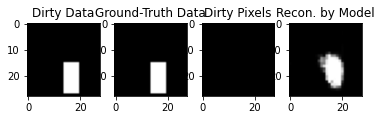

y_noise: 0


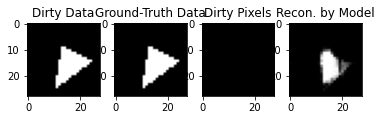

y_noise: 0


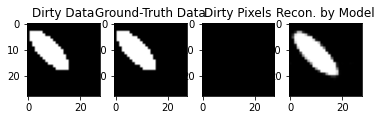

y_noise: 0


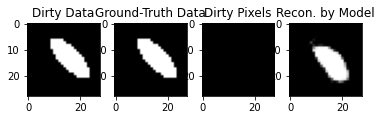

y_noise: 0


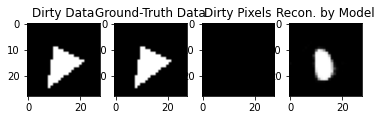

y_noise: 0


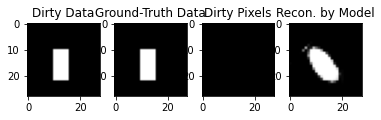

y_noise: 0


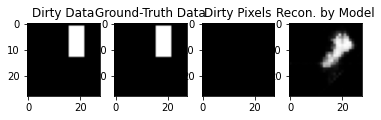

y_noise: 0


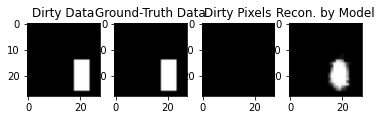

y_noise: 0


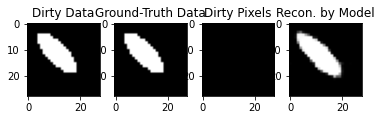

y_noise: 0


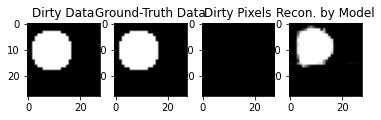

y_noise: 0


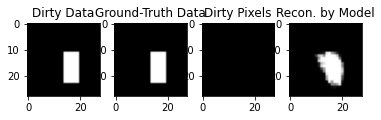

y_noise: 0


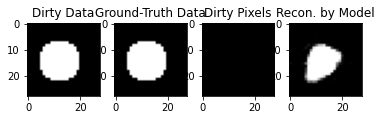

y_noise: 0


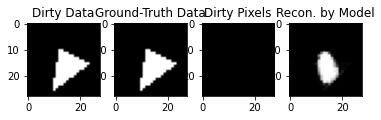

y_noise: 0


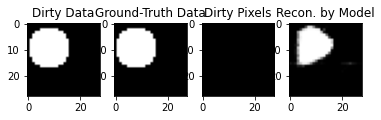

y_noise: 0


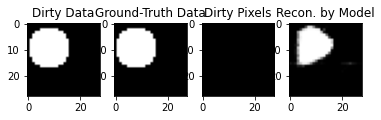

y_noise: 0


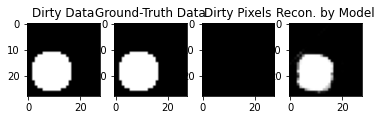

y_noise: 0


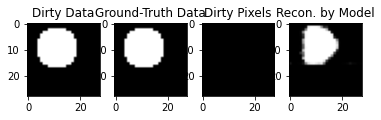

y_noise: 0


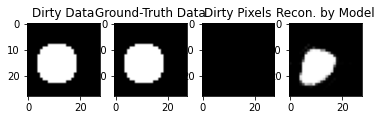

y_noise: 0


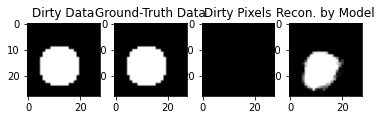

y_noise: 0


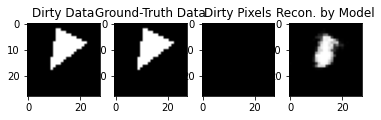

y_noise: 0


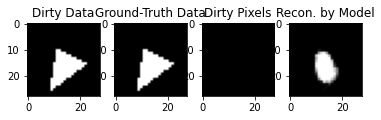

y_noise: 0


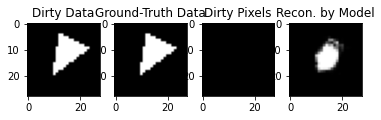

y_noise: 0


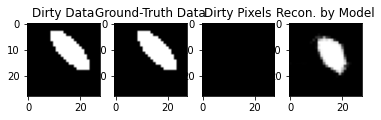

y_noise: 0


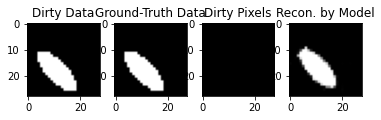

In [40]:
max_imgs_show = 25
y_noise_idxs_train = np.where(~y_noise_instance_train)[0]
some_idxs = np.random.permutation(y_noise_idxs_train)[:max_imgs_show]
# y_noise -- 1 if instance dirty; 0 if instance clean. (NOTE: inverted meaning in generative model)
    
for idx in some_idxs:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    ax[3].set_title("Recon. by Model")
    plt.show()


### Show Dirty Datapoints at Random

y_noise: 1


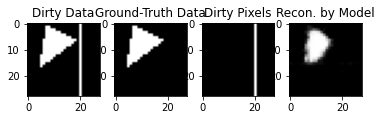

y_noise: 1


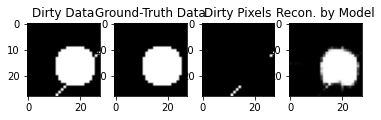

y_noise: 1


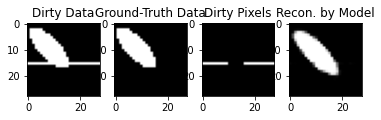

y_noise: 1


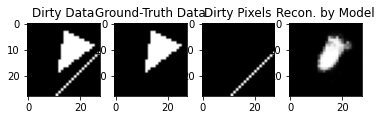

y_noise: 1


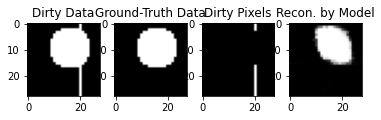

y_noise: 1


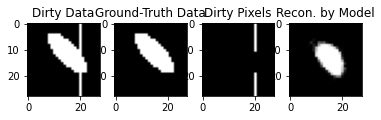

y_noise: 1


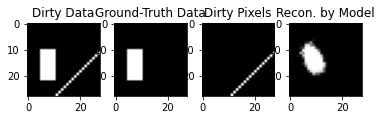

y_noise: 1


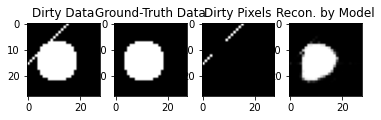

y_noise: 1


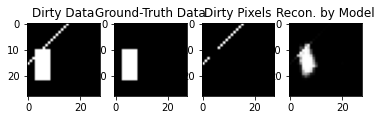

y_noise: 1


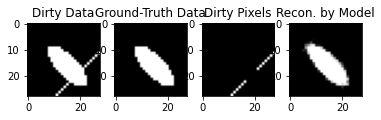

y_noise: 1


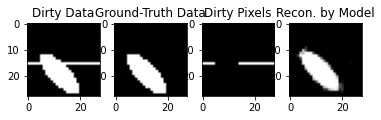

y_noise: 1


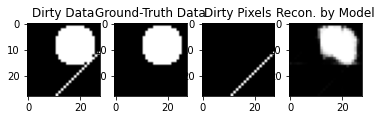

y_noise: 1


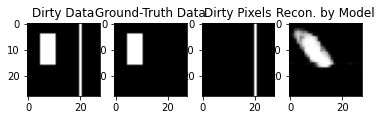

y_noise: 1


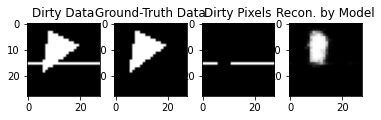

y_noise: 1


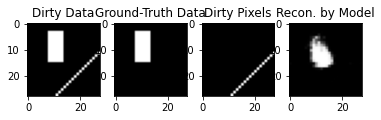

y_noise: 1


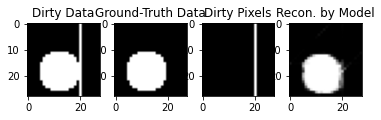

y_noise: 1


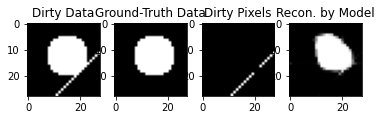

y_noise: 1


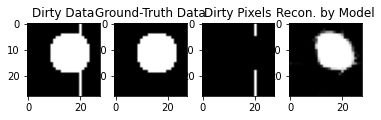

y_noise: 1


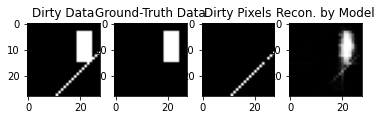

y_noise: 1


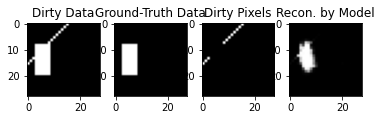

y_noise: 1


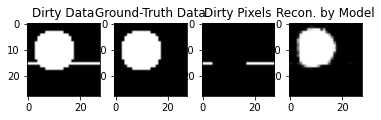

y_noise: 1


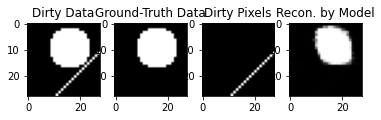

y_noise: 1


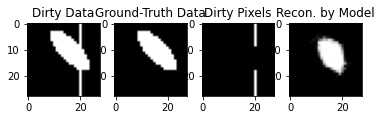

y_noise: 1


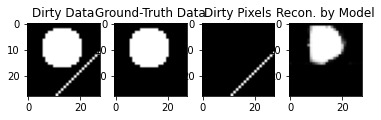

y_noise: 1


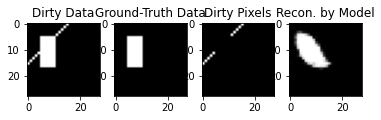

In [41]:
max_imgs_show = 25
y_noise_idxs_train = np.where(y_noise_instance_train)[0]
some_idxs = np.random.permutation(y_noise_idxs_train)[:max_imgs_show]
# y_noise -- 1 if instance dirty; 0 if instance clean. (NOTE: inverted meaning in generative model)
    
for idx in some_idxs:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[3].set_title("Recon. by Model")
    plt.show()



### Show per noise type images: y_noise_lists or y_noise_dict


Noise Tag: 0
Noise Indices: 
[1074, 2486, 847, 3208, 1286, 1959, 3241, 585, 2609, 223, 1834, 3804, 1618, 3708, 163, 1282, 569, 3417, 2556, 3003, 2868, 3866, 171, 2444, 3327, 3933, 3380, 496, 3591, 1448, 2391, 3229, 3073, 602, 2485, 3833, 3766, 3415, 2189, 1189, 2613, 774, 1218, 2408, 1429, 3566, 2383, 2219, 1782, 1810, 769, 977, 3869, 436, 1907, 1110, 2354, 2791, 175, 1970, 717, 427, 755, 47, 1625, 2283, 3928, 472, 725, 2826, 443, 1470, 1307, 3691, 2013, 1938, 198, 3576, 3279, 2578, 3340, 1542, 703, 1956, 1745, 694, 2946, 1871, 1386, 3194, 1626, 2418, 2123, 2345, 2461, 927, 2366, 1924, 2014, 3196, 2061, 3794, 3474, 2340, 2016, 1923, 1571, 3632, 1979, 1040, 425, 3800, 3040, 3526, 1574, 2691, 621, 3549, 946, 3002, 1479, 1531, 3999, 2441, 3106, 1853, 517, 3359, 1936, 1182, 3363, 3376, 971, 405, 916, 2508, 1930, 2322, 1785, 508, 779, 914, 1195, 3533, 1647, 1301, 1905, 1926, 1294, 2639, 2160, 2173, 2943, 3382, 1848, 85, 2832, 2930, 481, 1248, 3521, 3925, 2845, 534, 2246, 1947, 700, 3967, 62

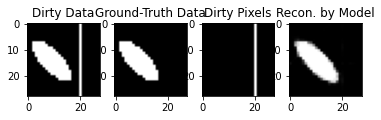

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


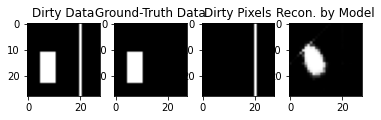

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


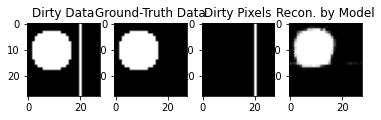

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


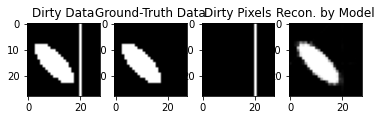

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


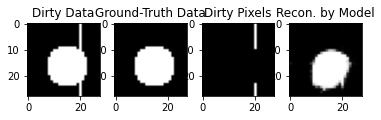

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


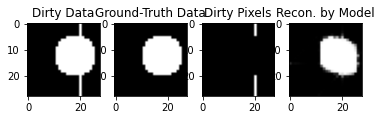

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


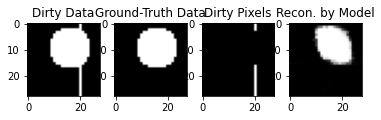

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


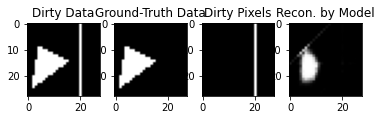

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


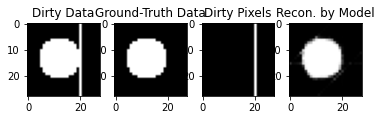

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


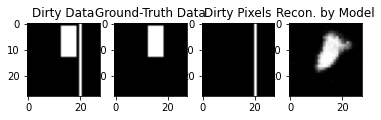







Noise Tag: 1
Noise Indices: 
[2494, 286, 3400, 1695, 3448, 1621, 2518, 3569, 3689, 3683, 1021, 1363, 651, 3134, 611, 2024, 2879, 3515, 2124, 3216, 1760, 1602, 57, 2310, 1895, 529, 2480, 3367, 3758, 561, 2178, 588, 265, 2218, 75, 1513, 1692, 329, 2666, 1250, 734, 2303, 104, 3776, 1567, 1710, 2858, 304, 1787, 3729, 2042, 3393, 345, 962, 642, 2103, 2190, 1224, 2114, 3613, 2595, 2196, 154, 3508, 3711, 2415, 938, 3421, 3, 2665, 2802, 2281, 1018, 3432, 2798, 1126, 1374, 704, 1774, 3817, 2547, 3529, 3978, 3029, 13, 1358, 632, 3910, 817, 376, 1744, 3170, 1950, 1004, 1058, 1207, 1191, 3436, 457, 2818, 650, 3809, 215, 2394, 723, 1026, 229, 2733, 2, 3771, 3233, 285, 1245, 365, 1098, 3390, 702, 2596, 3045, 3242, 2456, 1931, 1029, 320, 3466, 3405, 2829, 996, 283, 3410, 3901, 763, 1138, 237, 3088, 3617, 3681, 3065, 1801, 2874, 2900, 2931, 587, 2305, 1468, 339, 3567, 1263, 2191, 550, 2502, 3594, 66, 3025, 1707, 3899, 2187, 1533, 3462, 2070, 296, 1990, 3525, 2323, 1315, 374, 3947, 3547, 3627, 20

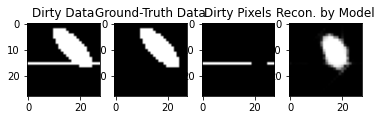

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


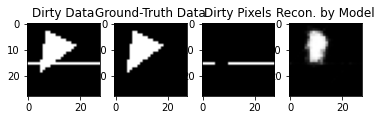

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


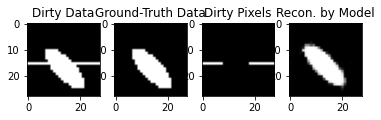

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


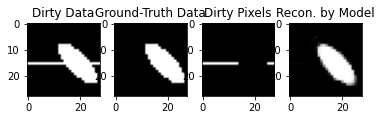

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


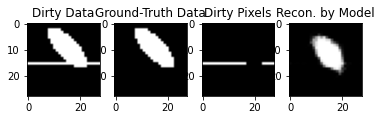

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


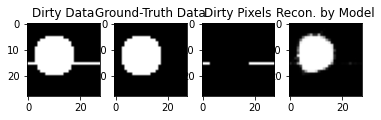

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


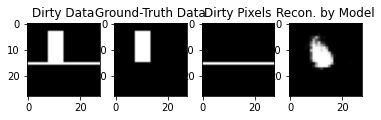

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


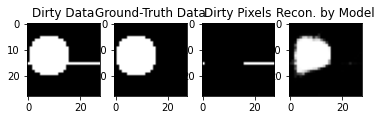

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


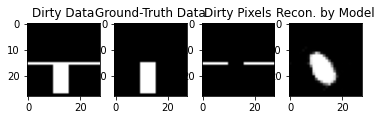

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


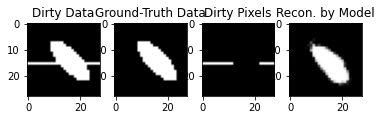







Noise Tag: 2
Noise Indices: 
[3287, 2577, 3902, 2709, 280, 640, 3014, 574, 248, 1090, 2158, 2164, 3353, 521, 24, 1549, 1412, 3243, 3222, 2021, 760, 2893, 854, 3676, 1822, 2567, 2777, 444, 2155, 3322, 1199, 2736, 212, 605, 2458, 1382, 1767, 3994, 1023, 735, 3074, 1627, 3541, 3789, 3907, 3477, 108, 731, 988, 253, 219, 3488, 1739, 488, 3153, 3274, 3812, 2847, 3517, 3111, 736, 3922, 3888, 838, 3148, 21, 382, 1401, 469, 1354, 3494, 1406, 199, 3101, 1749, 2237, 861, 244, 416, 3923, 1230, 751, 568, 3524, 732, 535, 1597, 3163, 3486, 2541, 2121, 1394, 3184, 1033, 370, 1439, 3532, 625, 3375, 3048, 786, 1463, 1994, 2232, 1091, 101, 1454, 3309, 1206, 1863, 3112, 2935, 886, 1444, 3643, 3404, 1279, 2972, 315, 148, 672, 1087, 1024, 3237, 1234, 1216, 1672, 3824, 1162, 1208, 3527, 1657, 1667, 2068, 3203, 2448, 3915, 318, 656, 943, 307, 1329, 1212, 3951, 391, 194, 816, 3411, 679, 1326, 526, 3602, 2241, 3094, 3064, 581, 1285, 281, 2591, 2606, 3461, 1591, 863, 3136, 3253, 3133, 274, 1311, 1519, 3036

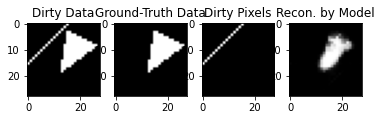

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


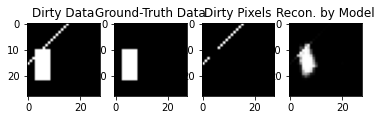

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


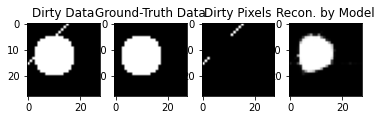

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


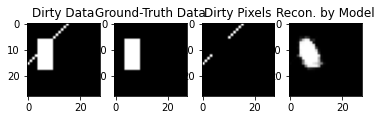

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


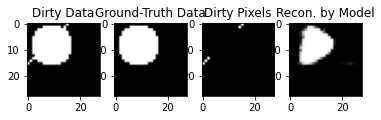

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


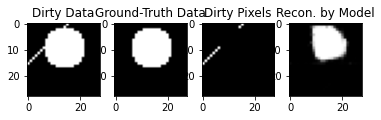

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


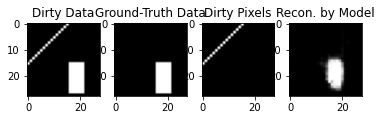

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


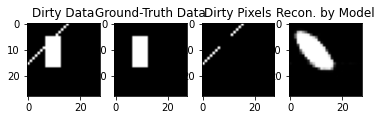

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


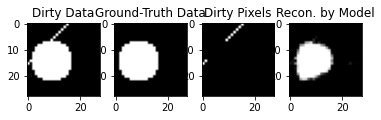

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


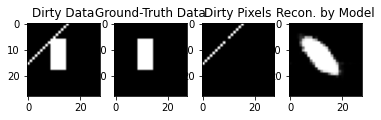







Noise Tag: 3
Noise Indices: 
[893, 202, 42, 2702, 1243, 3548, 3316, 3100, 2558, 2181, 3126, 1974, 1932, 3395, 1875, 2688, 394, 1253, 3490, 1001, 532, 3302, 3830, 684, 3697, 726, 693, 1844, 815, 1849, 870, 234, 1009, 3299, 937, 966, 1438, 2206, 1507, 2682, 1537, 2051, 1901, 2966, 1421, 3337, 3219, 3742, 1178, 2392, 810, 589, 297, 900, 2250, 2864, 1164, 3444, 3396, 2627, 2805, 2449, 2778, 3619, 2171, 3028, 873, 2548, 3572, 2797, 2538, 2435, 1289, 3024, 1802, 1645, 3612, 2212, 3763, 3956, 969, 1462, 3858, 2017, 485, 3780, 420, 3540, 3082, 951, 3853, 2721, 1046, 2511, 118, 1449, 476, 3714, 3563, 2951, 1933, 3458, 2906, 3429, 2108, 3171, 266, 68, 1214, 259, 1435, 3737, 2555, 2174, 216, 3864, 37, 3701, 1048, 317, 3657, 2497, 2285, 813, 81, 76, 3670, 842, 818, 359, 869, 565, 3652, 3290, 401, 2455, 980, 2539, 2959, 1966, 756, 1656, 609, 1176, 2221, 1028, 1980, 2139, 2960, 3531, 182, 3738, 784, 3188, 399, 2244, 2697, 245, 269, 2938, 2597, 428, 1318, 1577, 408, 1754, 1314, 1005, 3813, 3554

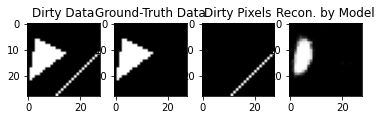

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


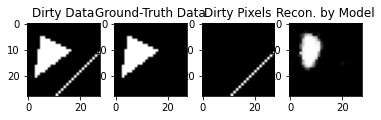

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


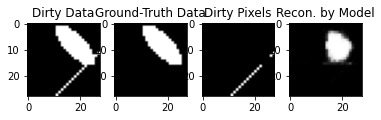

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


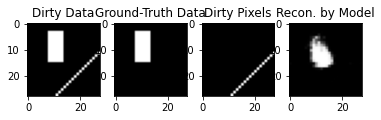

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


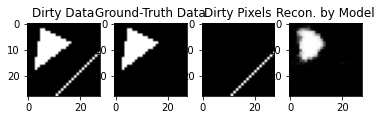

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


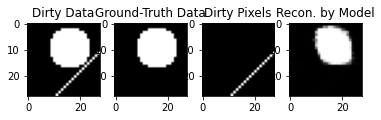

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


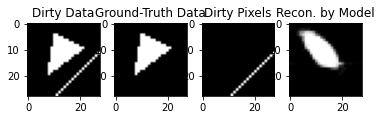

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


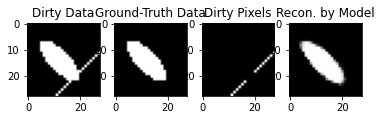

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


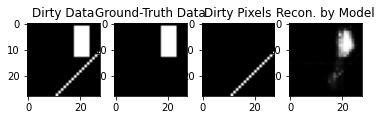

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


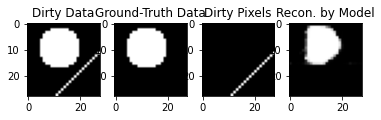

In [42]:
## show per noise type images: y_noise_lists or y_noise_dict

max_show_n = 10

for noise_key, noise_idxs in y_noise_dict_train.items():
    
    print("Noise Tag: {}".format(noise_key))
    print("Noise Indices: \n{}".format(noise_idxs))
    
    _selected_idxs = np.random.permutation(noise_idxs)[:max_show_n]
    
    for idx in _selected_idxs:
    
        print("y_class (clean): {} | y_noise: {} | y_noise_tag (noise type): {}".format(
            0, y_noise_instance_train[idx], noise_key)) # y_class_train[idx]
        fig, ax = plt.subplots(1,4)
        ax[0].imshow(x_train_orig[idx,...],cmap="gray")
        ax[0].set_title("Dirty Data")
        ax[1].imshow(x_train_clean_orig[idx,...],cmap="gray")
        ax[1].set_title("Ground-Truth Data")
        ax[2].imshow(y_noise_pixels_train[idx,...],cmap="gray")
        ax[2].set_title("Dirty Pixels")
        #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
        ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
        ax[3].set_title("Recon. by Model")
        plt.show()
        
    print("\n\n\n\n\n")



### Show Trusted Set (Clean Ground-Truth, Train Data, Recon)

In [43]:
len(trusted_idxs_train)

400

y_noise: 0


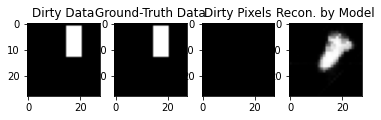

y_noise: 0


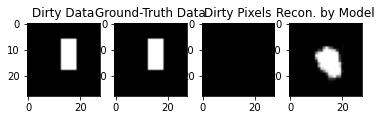

y_noise: 0


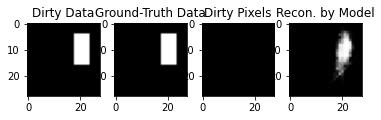

y_noise: 0


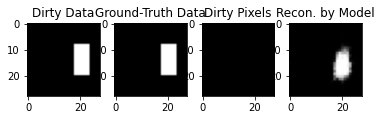

y_noise: 0


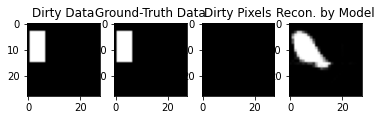

y_noise: 0


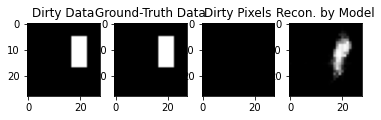

y_noise: 0


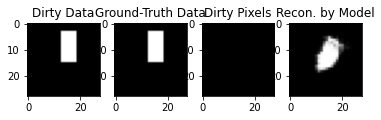

y_noise: 0


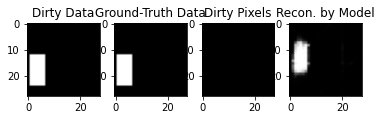

y_noise: 0


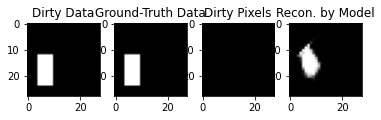

y_noise: 0


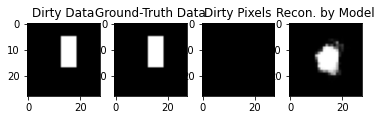

y_noise: 0


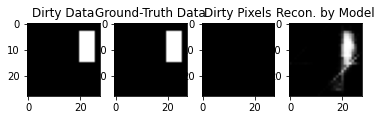

y_noise: 0


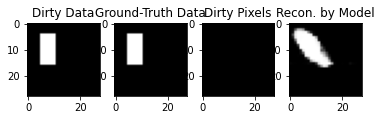

y_noise: 0


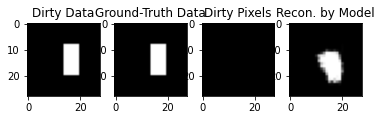

y_noise: 0


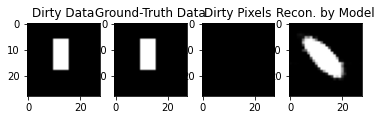

y_noise: 0


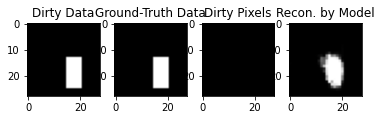

y_noise: 0


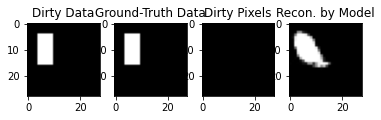

y_noise: 0


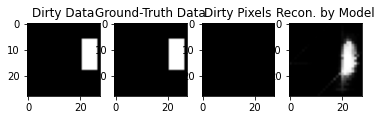

y_noise: 0


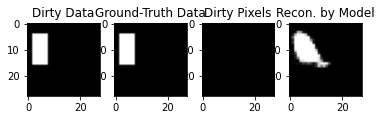

y_noise: 0


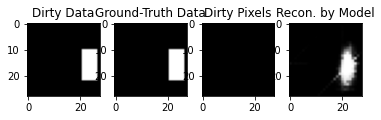

y_noise: 0


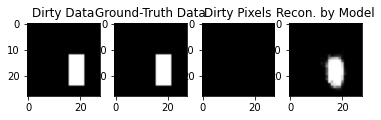

y_noise: 0


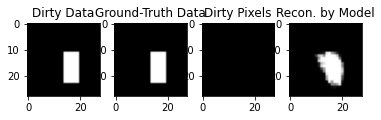

y_noise: 0


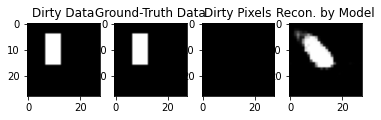

y_noise: 0


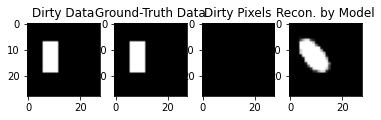

y_noise: 0


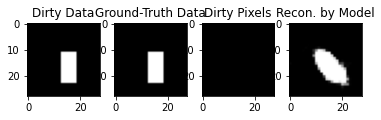

y_noise: 0


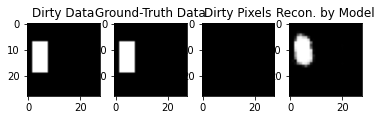

y_noise: 0


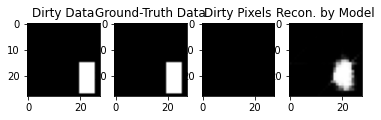

y_noise: 0


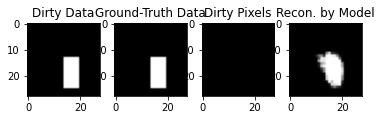

y_noise: 0


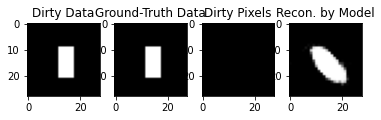

y_noise: 0


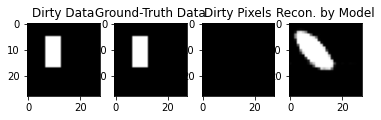

y_noise: 0


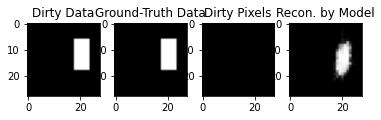

y_noise: 0


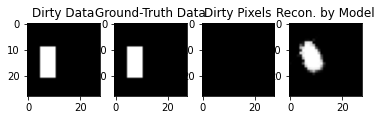

y_noise: 0


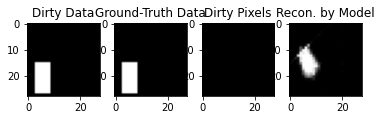

y_noise: 0


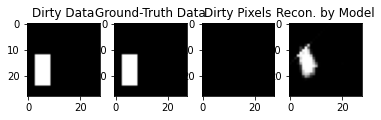

y_noise: 0


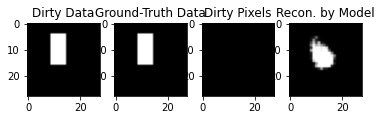

y_noise: 0


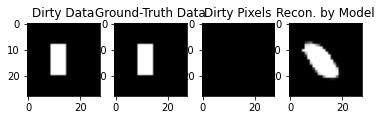

y_noise: 0


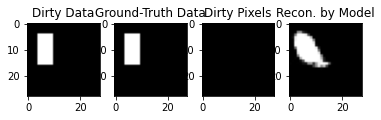

y_noise: 0


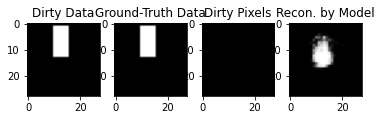

y_noise: 0


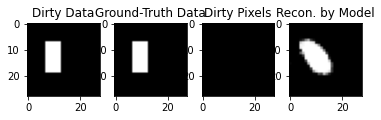

y_noise: 0


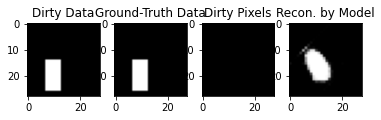

y_noise: 0


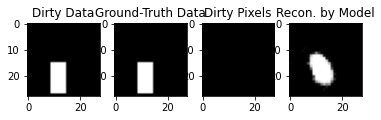

y_noise: 0


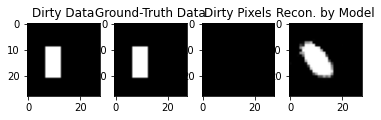

y_noise: 0


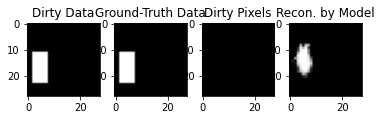

y_noise: 0


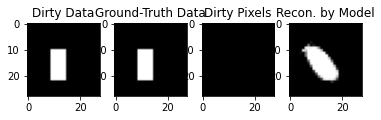

y_noise: 0


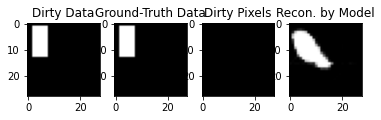

y_noise: 0


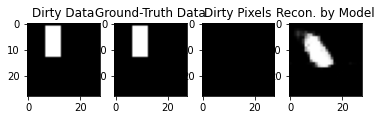

y_noise: 0


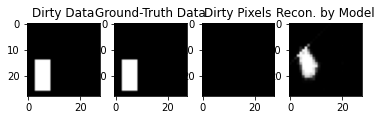

y_noise: 0


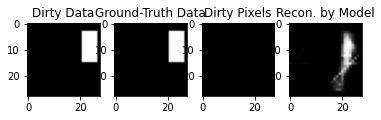

y_noise: 0


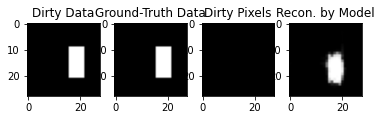

y_noise: 0


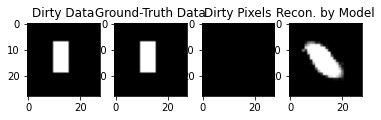

y_noise: 0


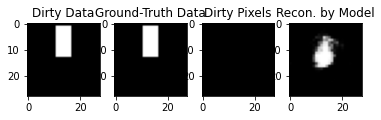

y_noise: 0


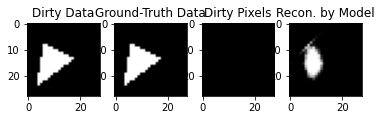

y_noise: 0


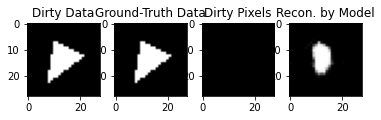

y_noise: 0


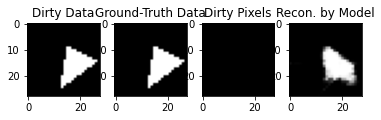

y_noise: 0


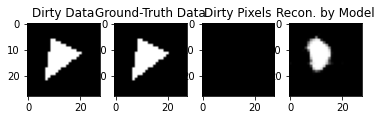

y_noise: 0


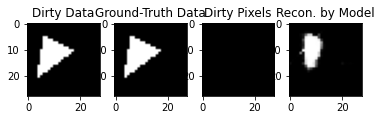

y_noise: 0


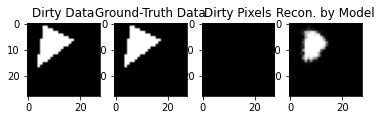

y_noise: 0


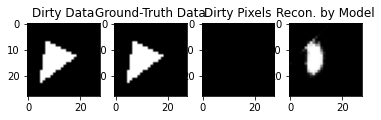

y_noise: 0


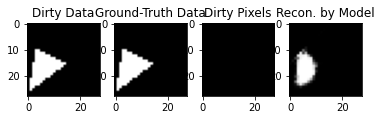

y_noise: 0


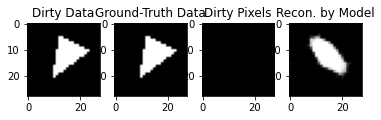

y_noise: 0


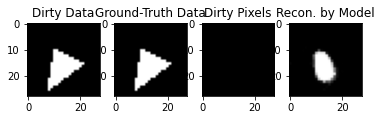

y_noise: 0


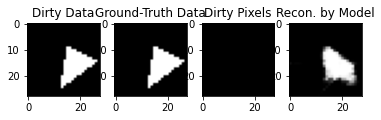

y_noise: 0


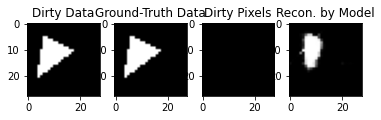

y_noise: 0


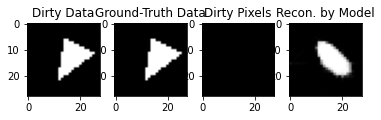

y_noise: 0


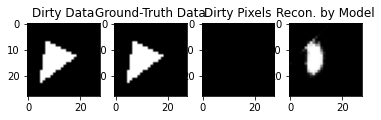

y_noise: 0


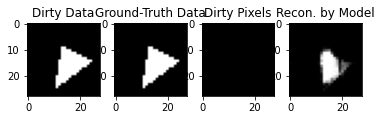

y_noise: 0


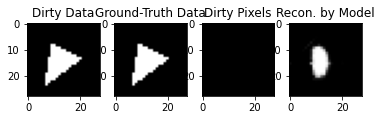

y_noise: 0


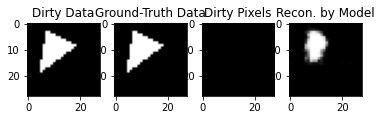

y_noise: 0


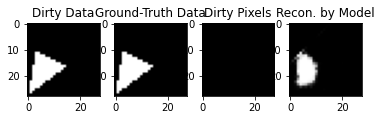

y_noise: 0


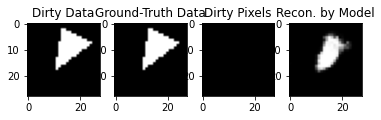

y_noise: 0


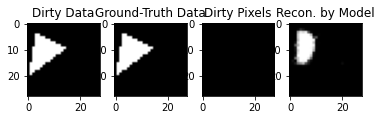

y_noise: 0


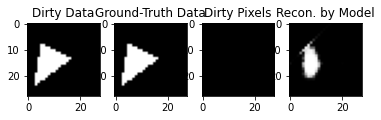

y_noise: 0


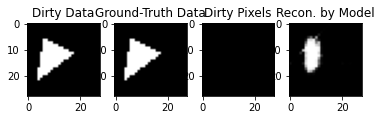

y_noise: 0


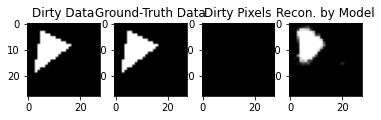

y_noise: 0


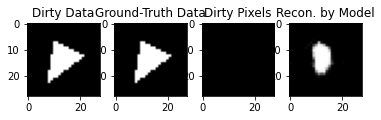

y_noise: 0


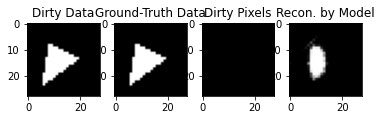

y_noise: 0


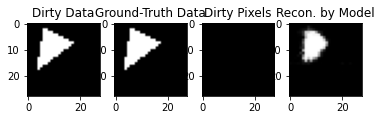

y_noise: 0


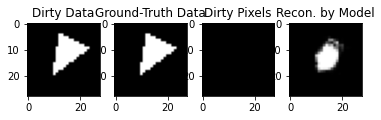

y_noise: 0


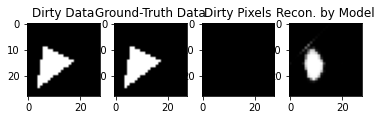

y_noise: 0


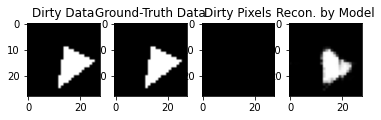

y_noise: 0


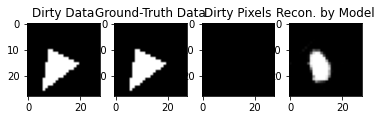

y_noise: 0


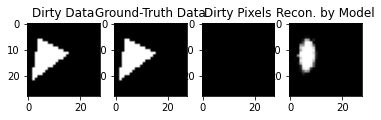

y_noise: 0


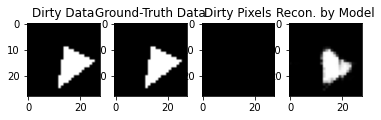

y_noise: 0


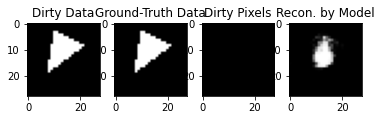

y_noise: 0


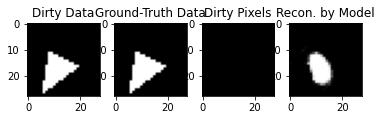

y_noise: 0


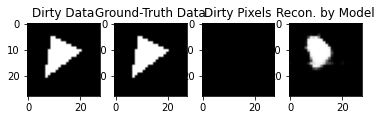

y_noise: 0


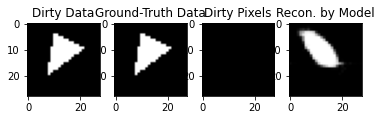

y_noise: 0


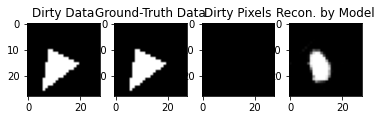

y_noise: 0


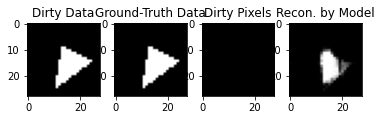

y_noise: 0


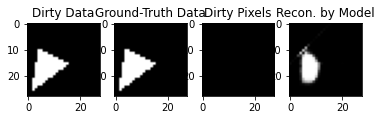

y_noise: 0


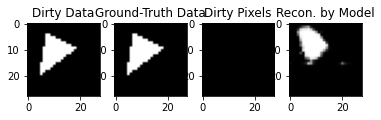

y_noise: 0


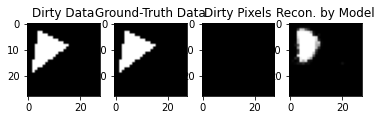

y_noise: 0


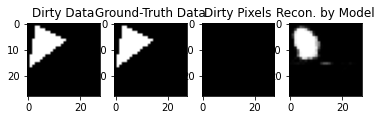

y_noise: 0


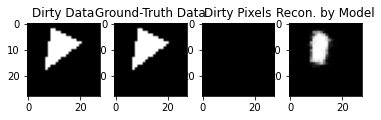

y_noise: 0


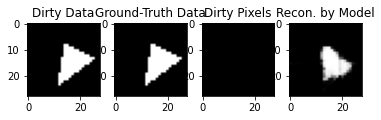

y_noise: 0


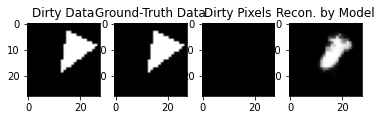

y_noise: 0


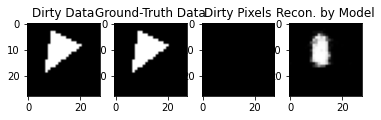

y_noise: 0


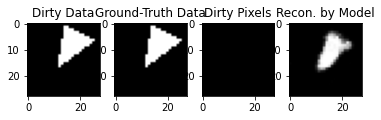

y_noise: 0


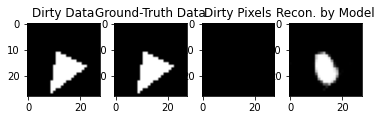

y_noise: 0


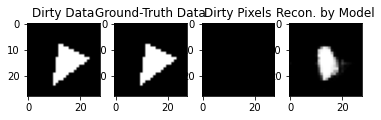

y_noise: 0


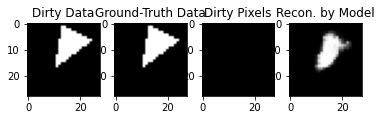

y_noise: 0


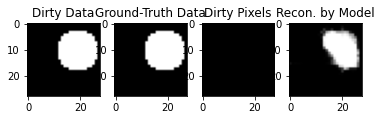

y_noise: 0


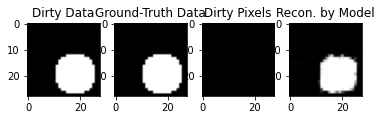

y_noise: 0


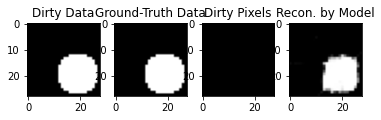

y_noise: 0


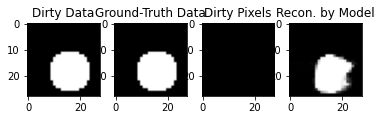

y_noise: 0


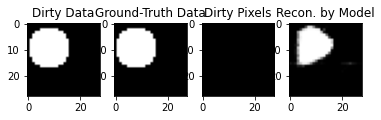

y_noise: 0


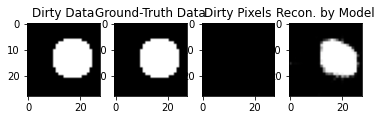

y_noise: 0


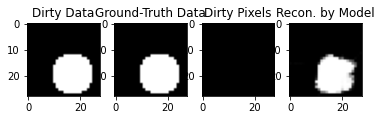

y_noise: 0


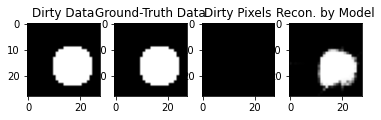

y_noise: 0


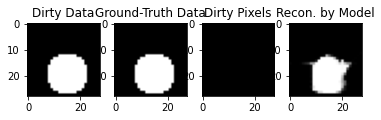

y_noise: 0


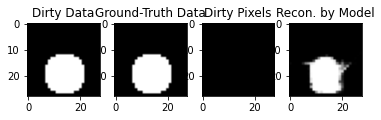

y_noise: 0


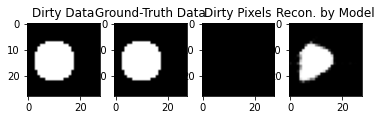

y_noise: 0


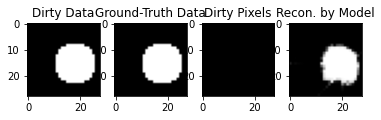

y_noise: 0


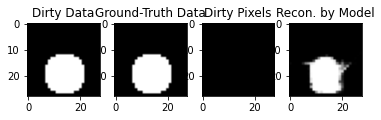

y_noise: 0


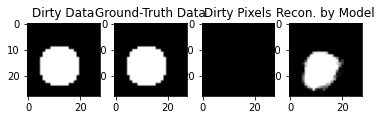

y_noise: 0


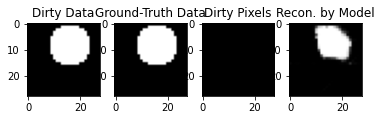

y_noise: 0


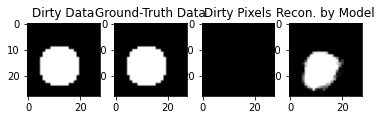

y_noise: 0


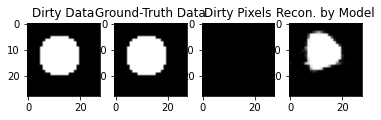

y_noise: 0


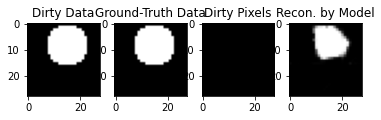

y_noise: 0


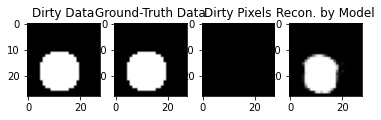

y_noise: 0


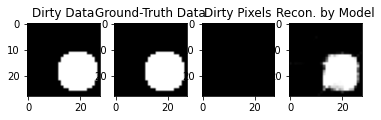

y_noise: 0


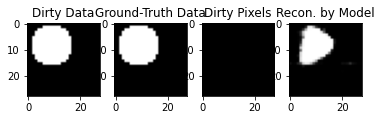

y_noise: 0


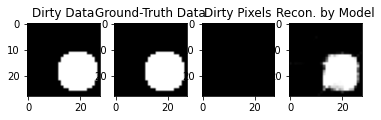

y_noise: 0


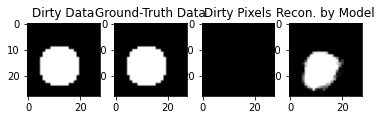

y_noise: 0


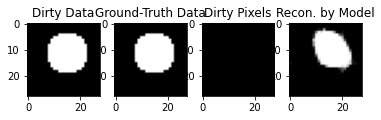

y_noise: 0


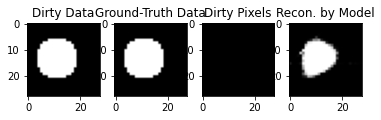

y_noise: 0


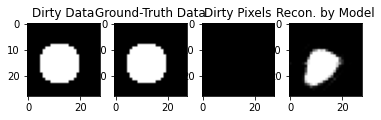

y_noise: 0


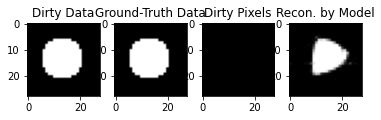

y_noise: 0


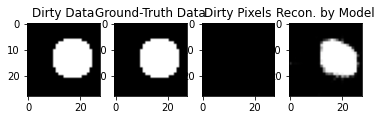

y_noise: 0


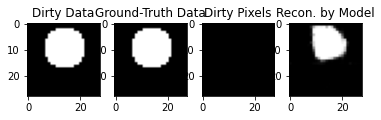

y_noise: 0


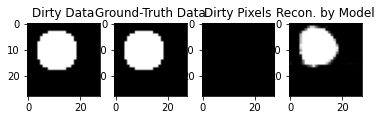

y_noise: 0


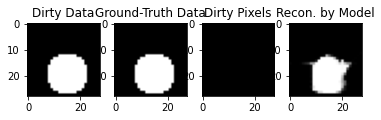

y_noise: 0


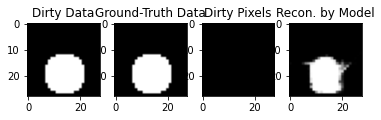

y_noise: 0


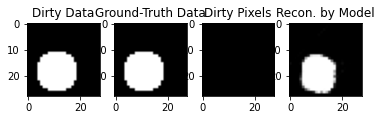

y_noise: 0


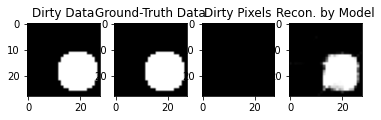

y_noise: 0


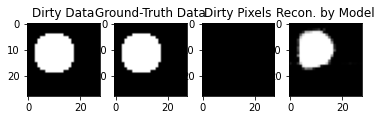

y_noise: 0


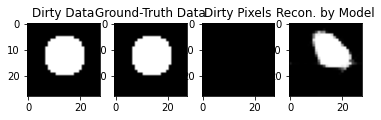

y_noise: 0


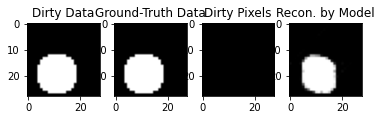

y_noise: 0


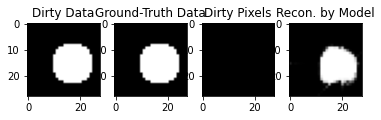

y_noise: 0


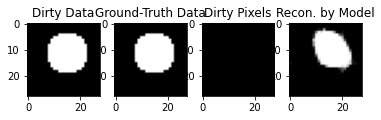

y_noise: 0


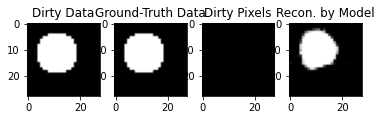

y_noise: 0


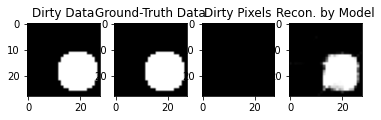

y_noise: 0


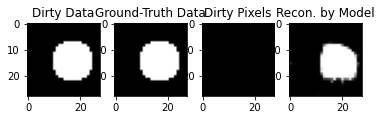

y_noise: 0


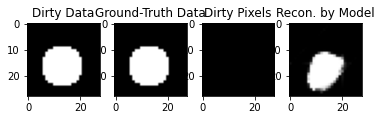

y_noise: 0


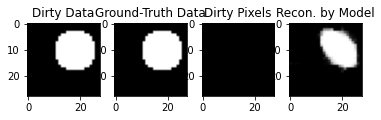

y_noise: 0


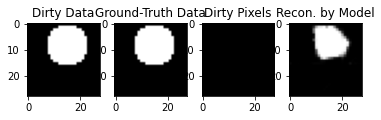

y_noise: 0


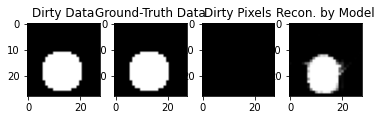

y_noise: 0


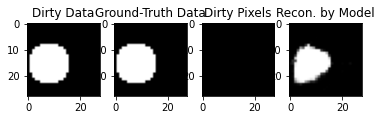

y_noise: 0


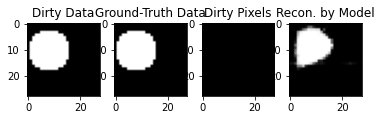

y_noise: 0


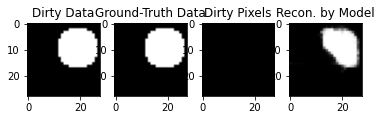

y_noise: 0


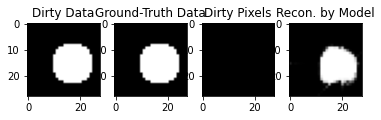

y_noise: 0


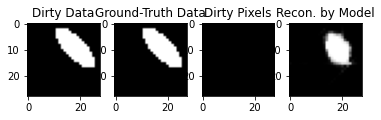

y_noise: 0


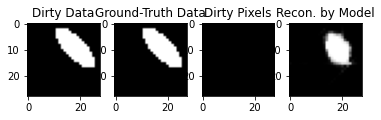

y_noise: 0


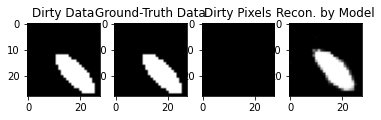

y_noise: 0


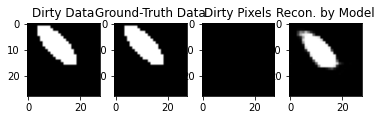

y_noise: 0


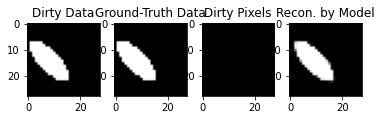

y_noise: 0


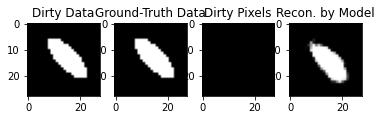

y_noise: 0


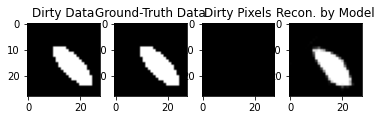

y_noise: 0


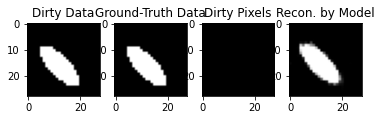

y_noise: 0


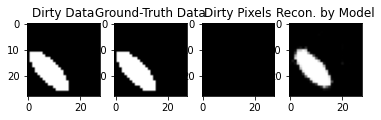

y_noise: 0


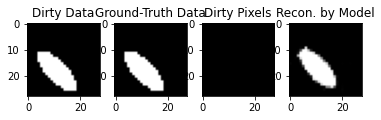

y_noise: 0


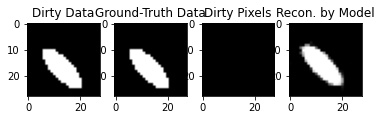

y_noise: 0


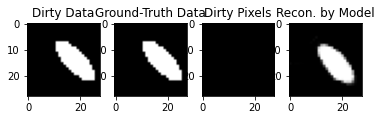

y_noise: 0


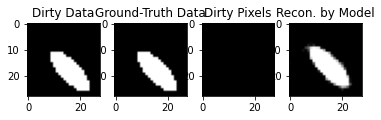

y_noise: 0


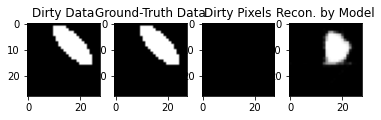

y_noise: 0


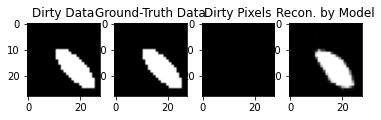

y_noise: 0


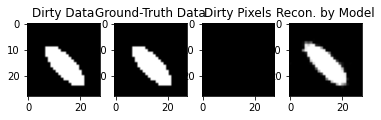

y_noise: 0


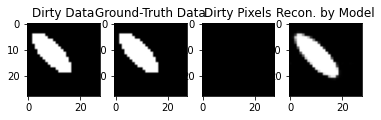

y_noise: 0


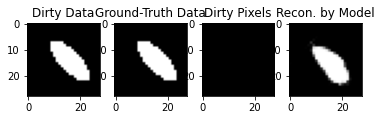

y_noise: 0


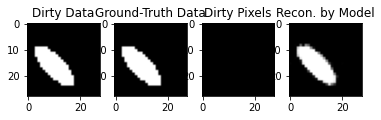

y_noise: 0


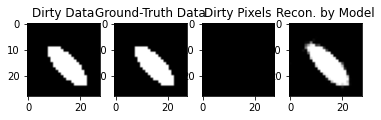

y_noise: 0


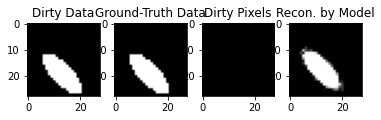

y_noise: 0


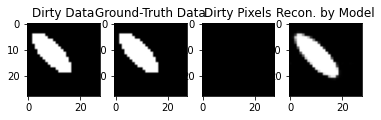

y_noise: 0


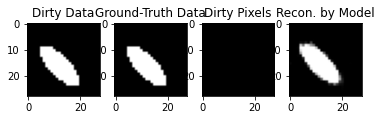

y_noise: 0


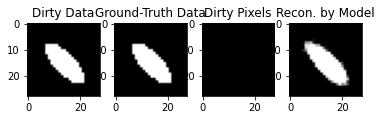

y_noise: 0


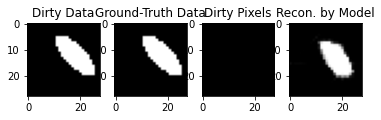

y_noise: 0


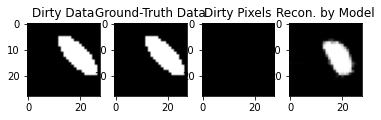

y_noise: 0


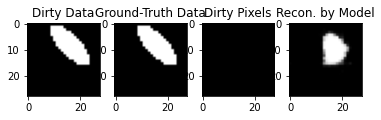

y_noise: 0


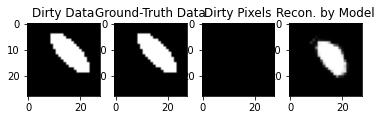

y_noise: 0


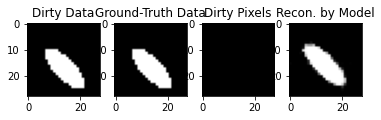

y_noise: 0


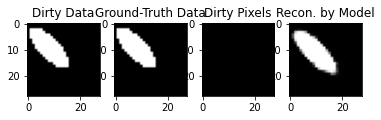

y_noise: 0


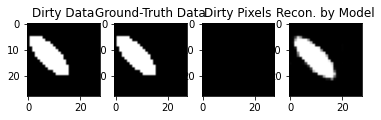

y_noise: 0


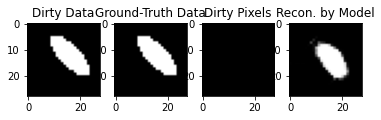

y_noise: 0


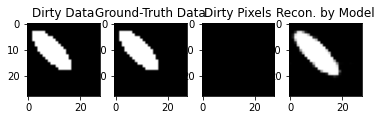

y_noise: 0


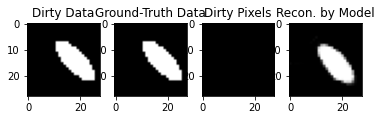

y_noise: 0


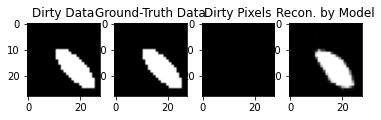

y_noise: 0


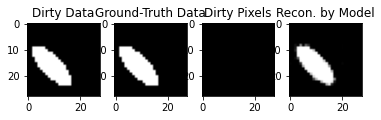

y_noise: 0


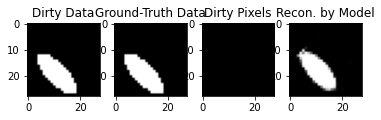

y_noise: 0


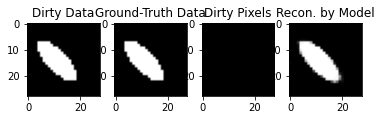

y_noise: 0


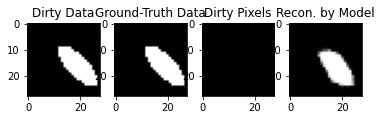

y_noise: 0


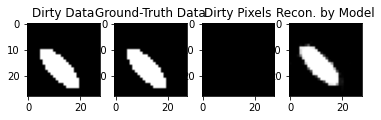

y_noise: 0


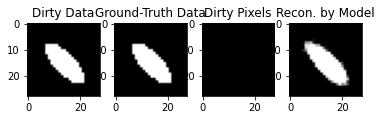

y_noise: 0


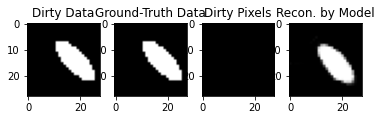

y_noise: 0


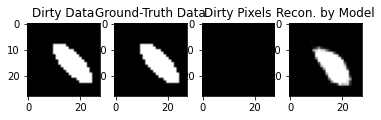

y_noise: 0


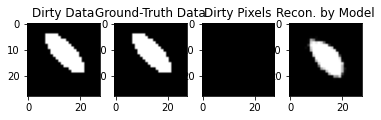

y_noise: 0


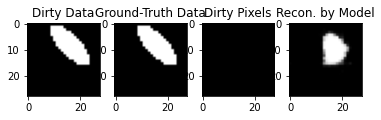

y_noise: 0


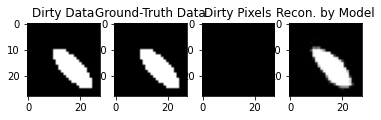

y_noise: 0


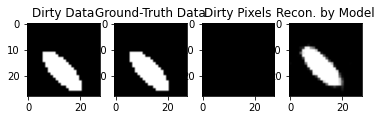

y_noise: 0


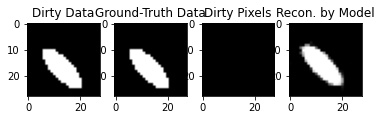

y_noise: 0


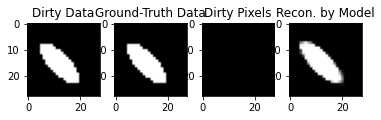

y_noise: 0


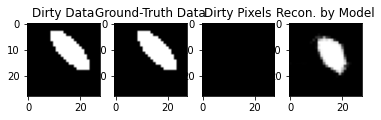

y_noise: 1


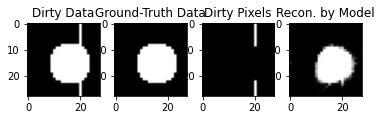

y_noise: 1


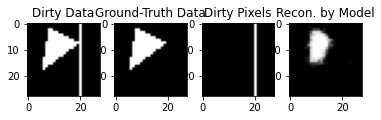

y_noise: 1


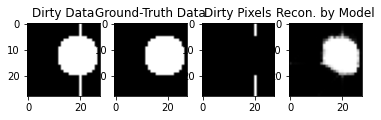

y_noise: 1


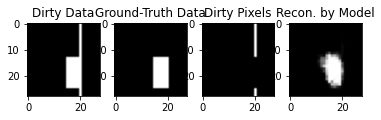

y_noise: 1


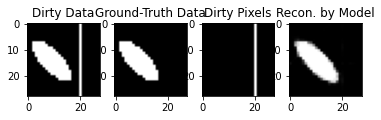

y_noise: 1


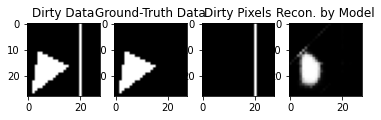

y_noise: 1


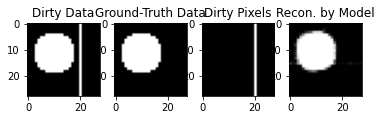

y_noise: 1


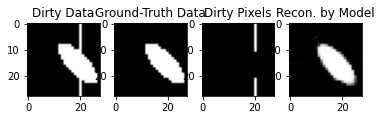

y_noise: 1


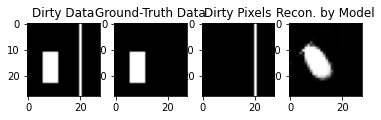

y_noise: 1


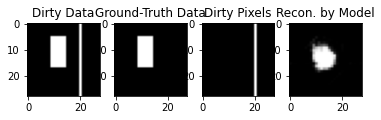

y_noise: 1


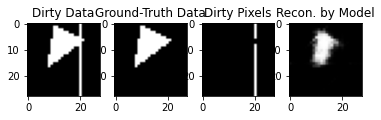

y_noise: 1


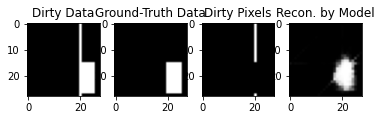

y_noise: 1


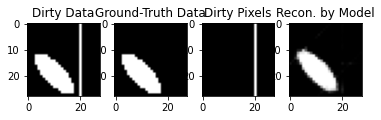

y_noise: 1


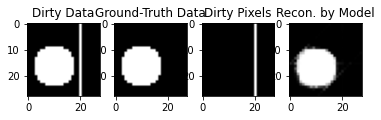

y_noise: 1


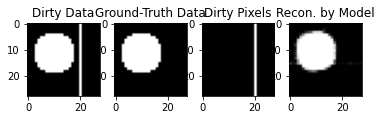

y_noise: 1


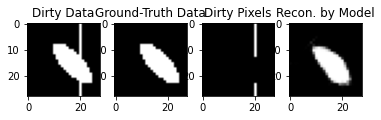

y_noise: 1


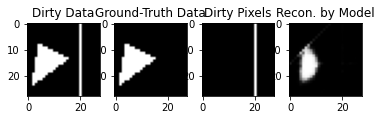

y_noise: 1


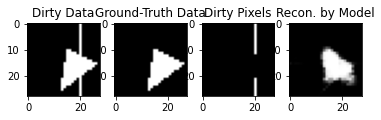

y_noise: 1


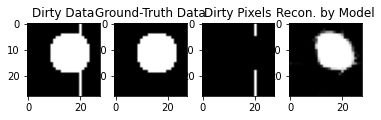

y_noise: 1


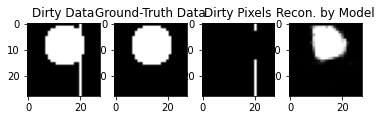

y_noise: 1


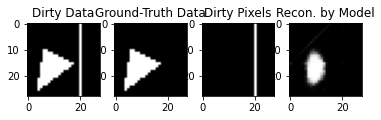

y_noise: 1


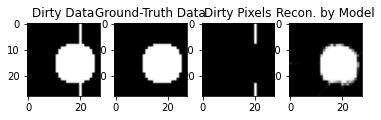

y_noise: 1


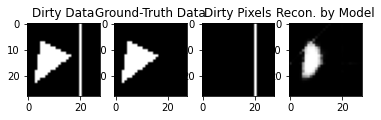

y_noise: 1


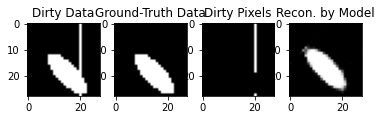

y_noise: 1


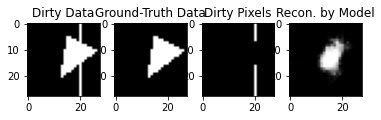

y_noise: 1


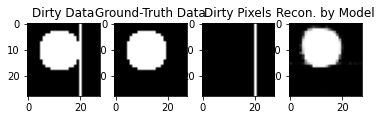

y_noise: 1


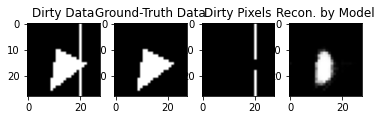

y_noise: 1


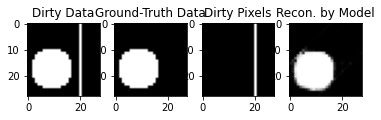

y_noise: 1


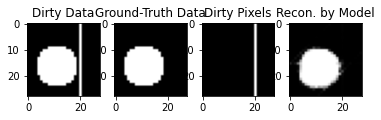

y_noise: 1


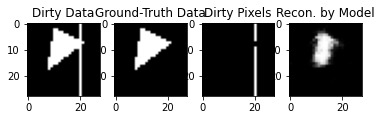

y_noise: 1


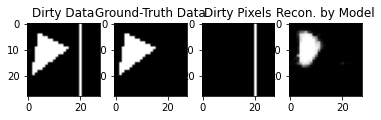

y_noise: 1


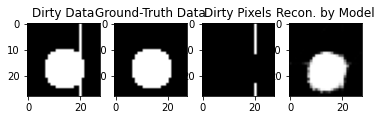

y_noise: 1


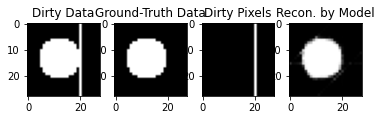

y_noise: 1


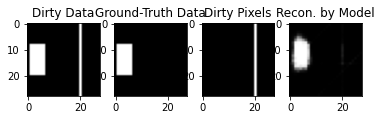

y_noise: 1


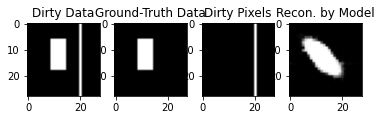

y_noise: 1


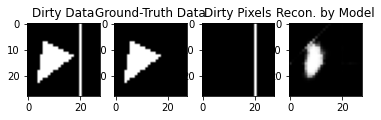

y_noise: 1


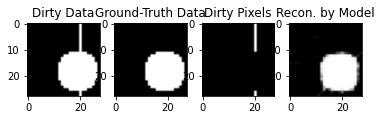

y_noise: 1


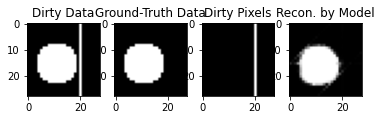

y_noise: 1


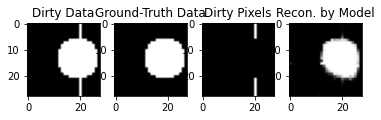

y_noise: 1


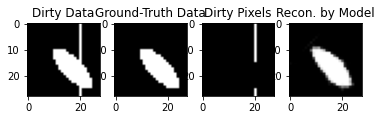

y_noise: 1


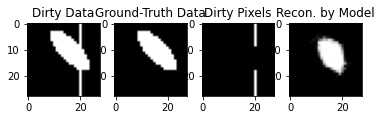

y_noise: 1


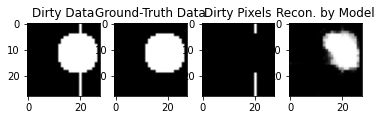

y_noise: 1


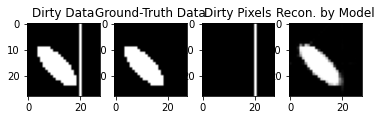

y_noise: 1


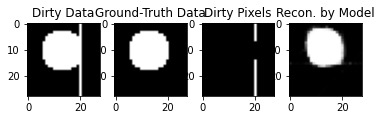

y_noise: 1


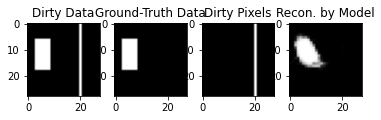

y_noise: 1


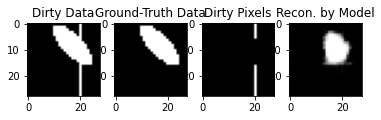

y_noise: 1


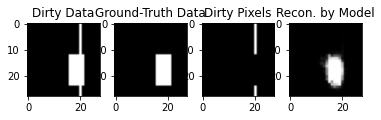

y_noise: 1


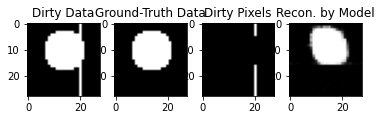

y_noise: 1


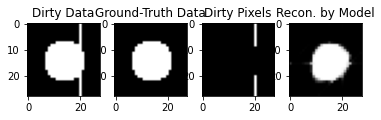

y_noise: 1


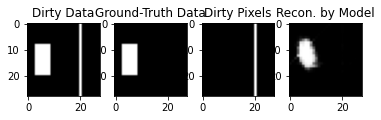

y_noise: 1


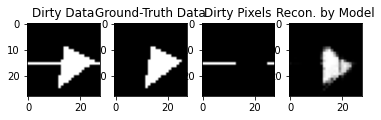

y_noise: 1


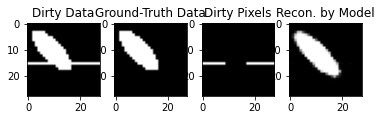

y_noise: 1


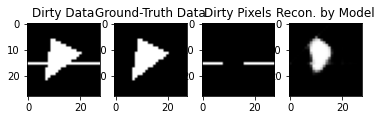

y_noise: 1


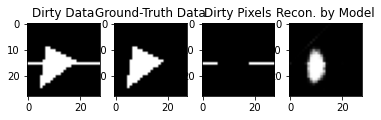

y_noise: 1


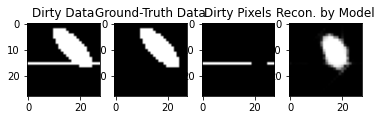

y_noise: 1


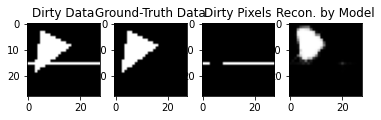

y_noise: 1


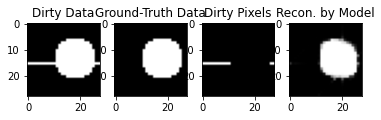

y_noise: 1


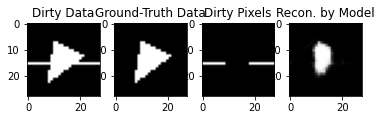

y_noise: 1


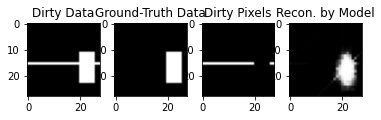

y_noise: 1


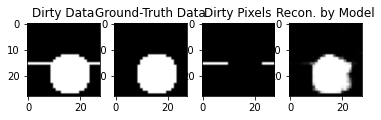

y_noise: 1


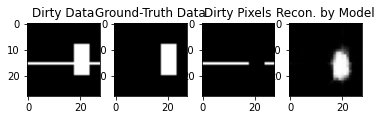

y_noise: 1


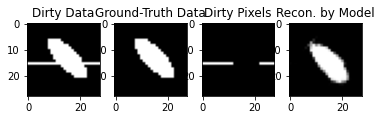

y_noise: 1


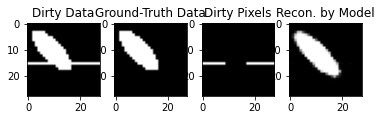

y_noise: 1


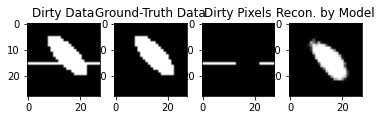

y_noise: 1


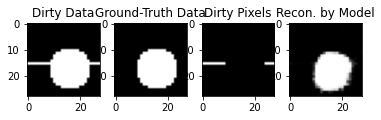

y_noise: 1


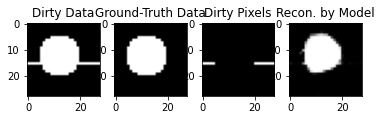

y_noise: 1


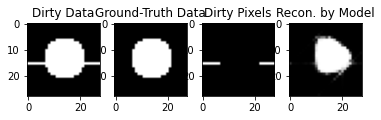

y_noise: 1


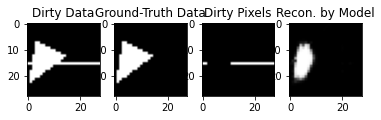

y_noise: 1


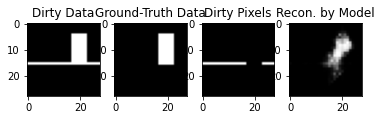

y_noise: 1


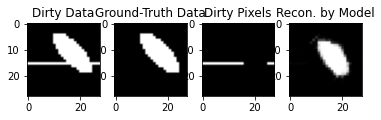

y_noise: 1


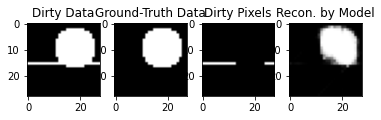

y_noise: 1


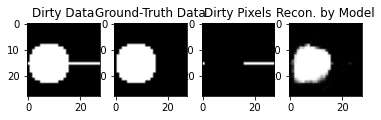

y_noise: 1


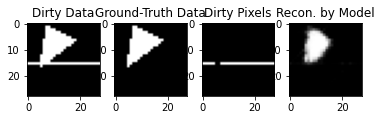

y_noise: 1


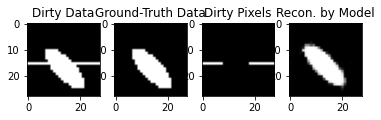

y_noise: 1


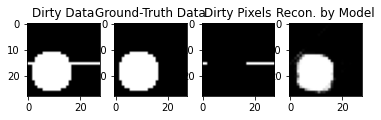

y_noise: 1


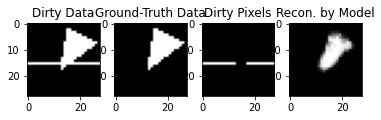

y_noise: 1


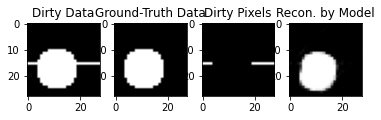

y_noise: 1


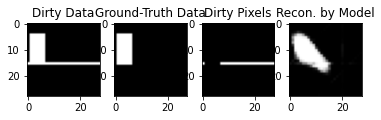

y_noise: 1


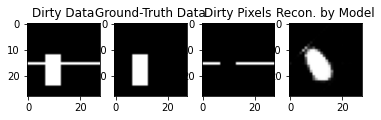

y_noise: 1


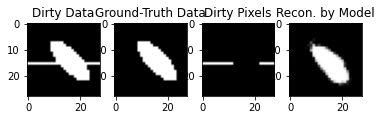

y_noise: 1


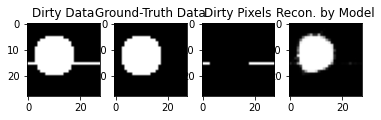

y_noise: 1


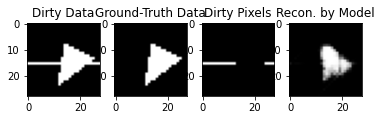

y_noise: 1


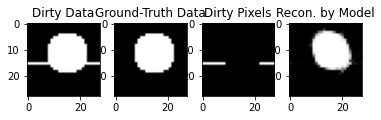

y_noise: 1


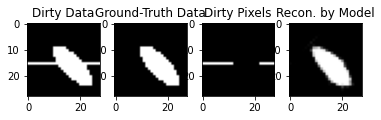

y_noise: 1


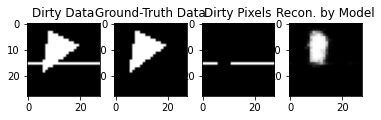

y_noise: 1


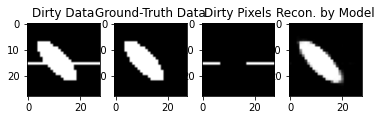

y_noise: 1


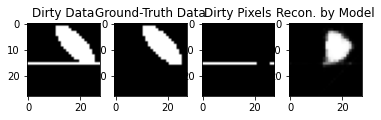

y_noise: 1


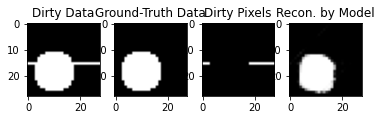

y_noise: 1


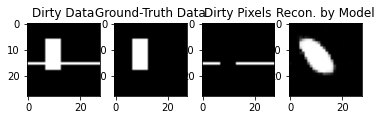

y_noise: 1


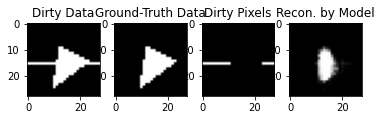

y_noise: 1


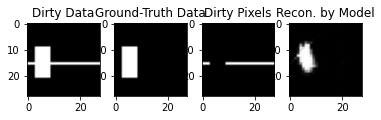

y_noise: 1


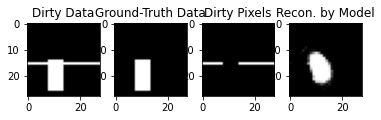

y_noise: 1


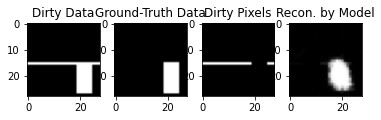

y_noise: 1


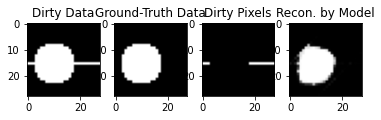

y_noise: 1


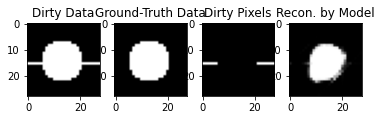

y_noise: 1


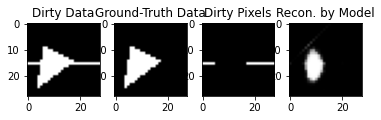

y_noise: 1


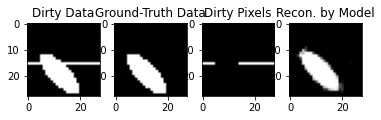

y_noise: 1


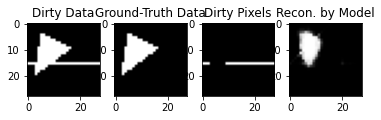

y_noise: 1


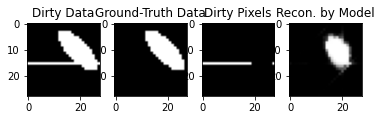

y_noise: 1


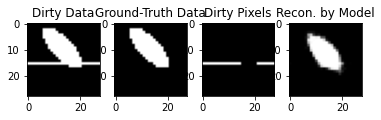

y_noise: 1


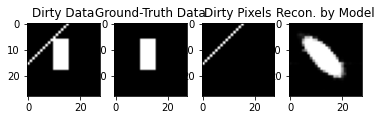

y_noise: 1


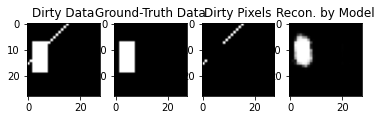

y_noise: 1


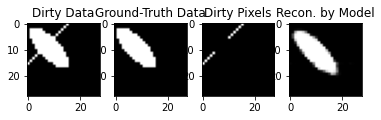

y_noise: 1


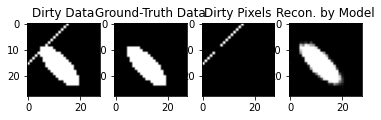

y_noise: 1


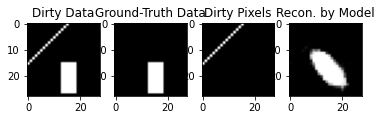

y_noise: 1


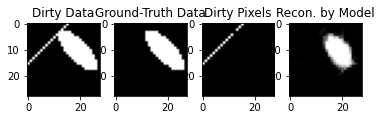

y_noise: 1


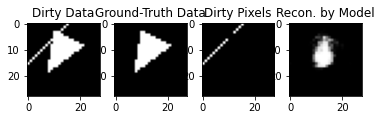

y_noise: 1


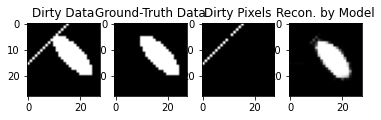

y_noise: 1


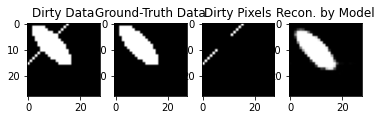

y_noise: 1


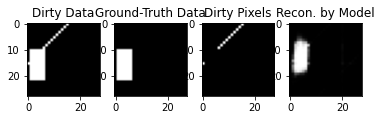

y_noise: 1


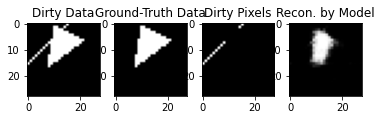

y_noise: 1


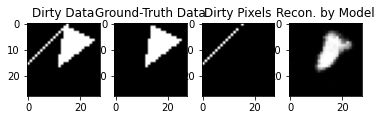

y_noise: 1


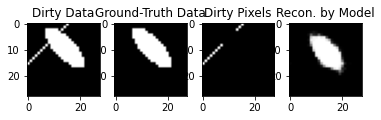

y_noise: 1


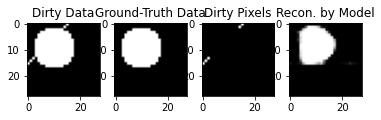

y_noise: 1


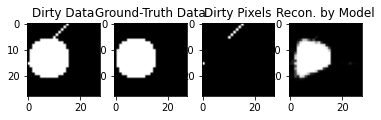

y_noise: 1


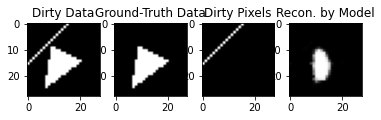

y_noise: 1


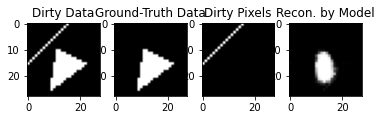

y_noise: 1


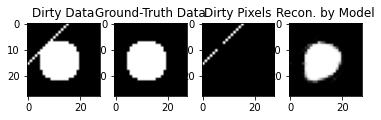

y_noise: 1


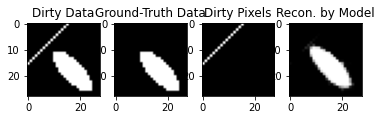

y_noise: 1


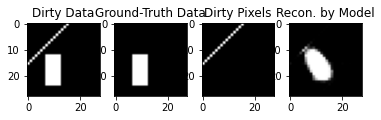

y_noise: 1


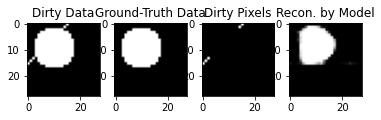

y_noise: 1


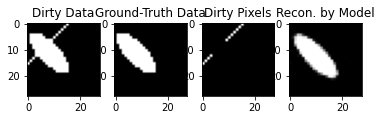

y_noise: 1


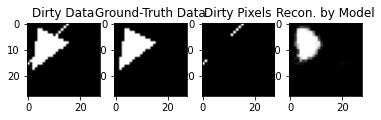

y_noise: 1


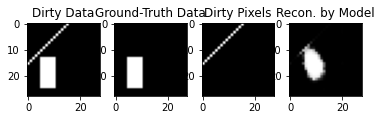

y_noise: 1


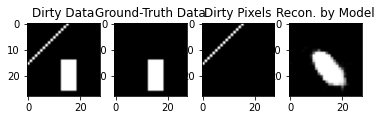

y_noise: 1


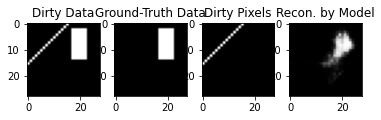

y_noise: 1


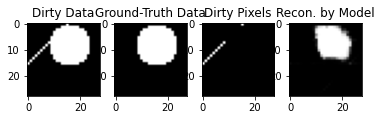

y_noise: 1


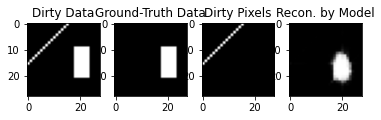

y_noise: 1


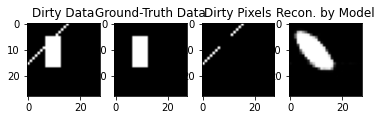

y_noise: 1


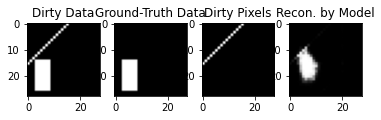

y_noise: 1


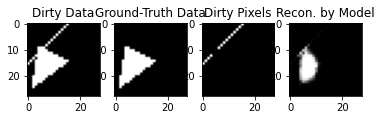

y_noise: 1


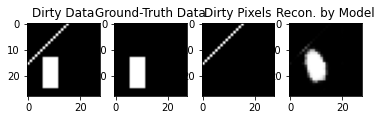

y_noise: 1


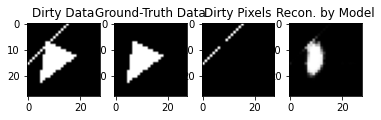

y_noise: 1


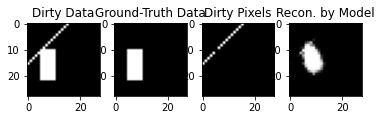

y_noise: 1


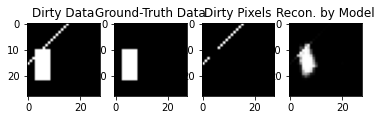

y_noise: 1


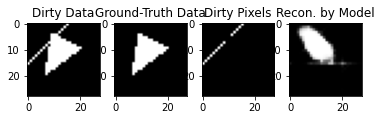

y_noise: 1


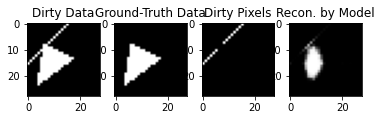

y_noise: 1


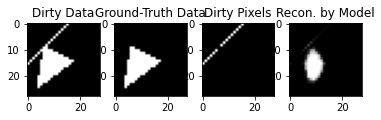

y_noise: 1


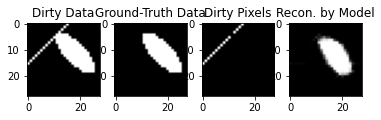

y_noise: 1


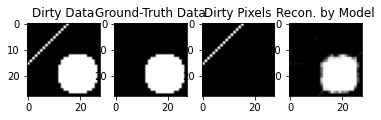

y_noise: 1


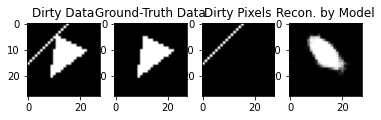

y_noise: 1


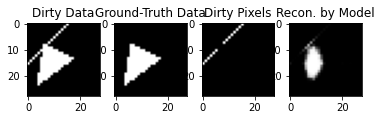

y_noise: 1


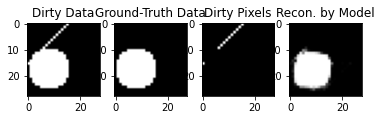

y_noise: 1


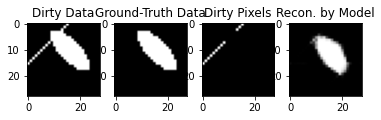

y_noise: 1


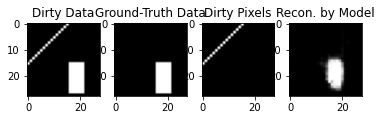

y_noise: 1


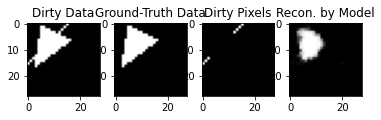

y_noise: 1


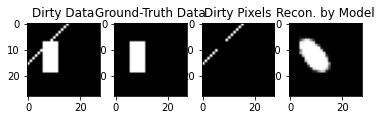

y_noise: 1


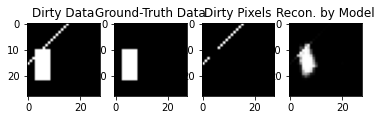

y_noise: 1


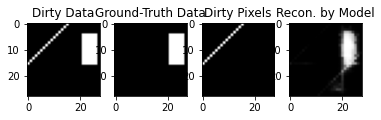

y_noise: 1


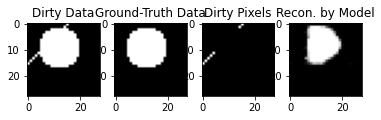

y_noise: 1


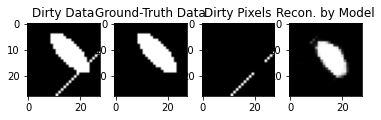

y_noise: 1


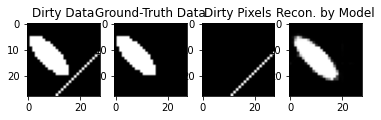

y_noise: 1


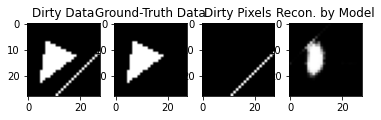

y_noise: 1


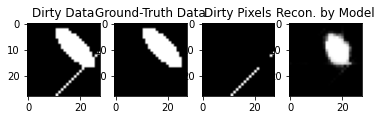

y_noise: 1


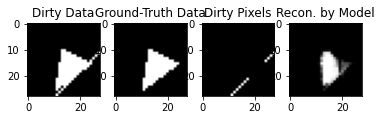

y_noise: 1


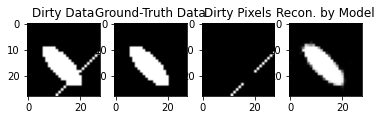

y_noise: 1


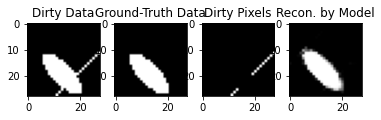

y_noise: 1


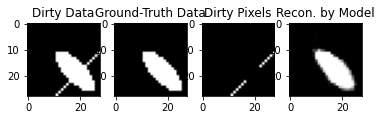

y_noise: 1


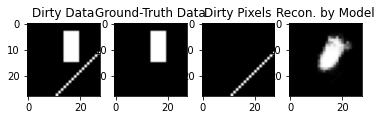

y_noise: 1


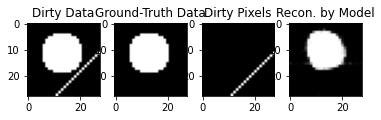

y_noise: 1


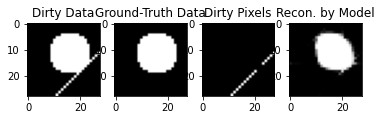

y_noise: 1


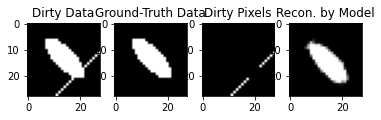

y_noise: 1


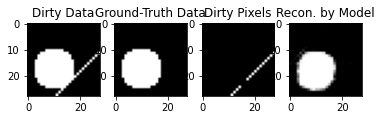

y_noise: 1


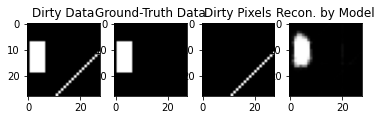

y_noise: 1


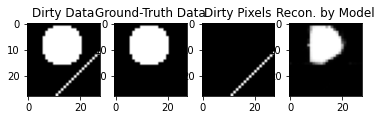

y_noise: 1


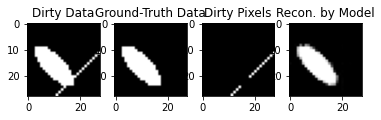

y_noise: 1


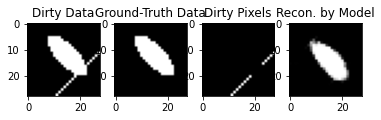

y_noise: 1


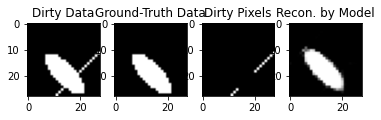

y_noise: 1


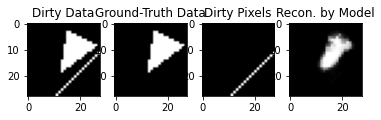

y_noise: 1


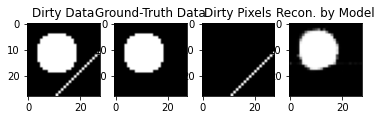

y_noise: 1


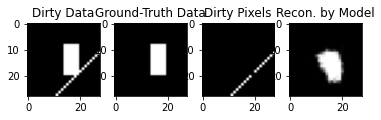

y_noise: 1


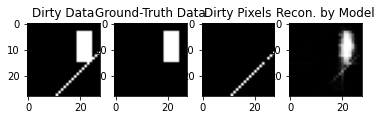

y_noise: 1


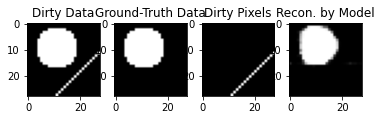

y_noise: 1


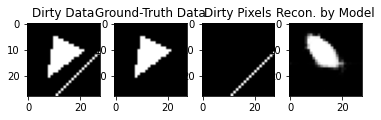

y_noise: 1


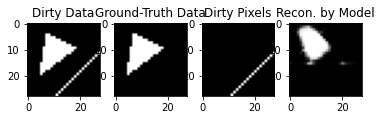

y_noise: 1


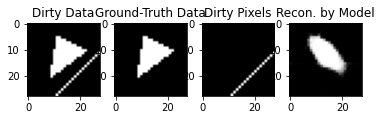

y_noise: 1


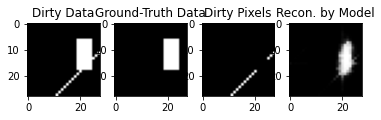

y_noise: 1


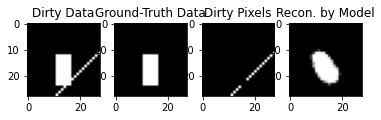

y_noise: 1


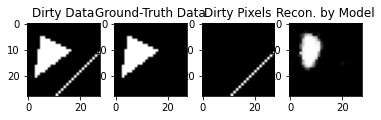

y_noise: 1


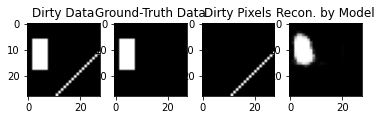

y_noise: 1


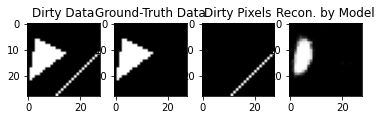

y_noise: 1


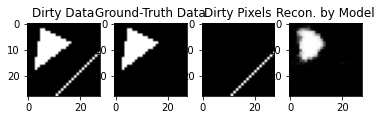

y_noise: 1


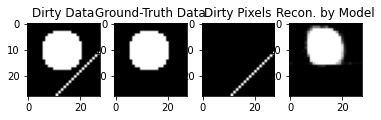

y_noise: 1


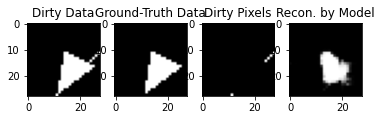

y_noise: 1


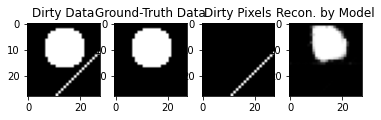

y_noise: 1


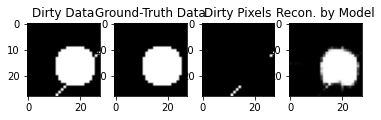

y_noise: 1


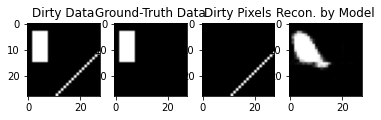

y_noise: 1


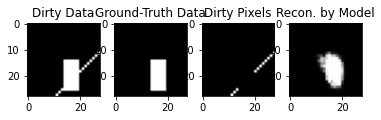

y_noise: 1


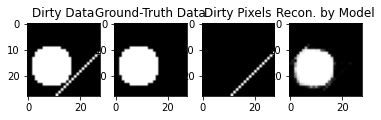

y_noise: 1


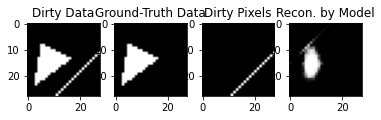

y_noise: 1


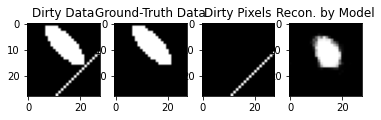

y_noise: 1


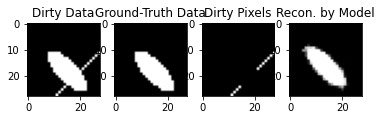

y_noise: 1


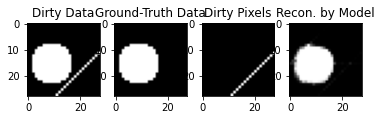

y_noise: 1


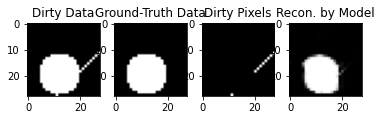

y_noise: 1


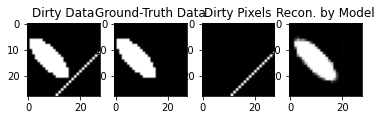

y_noise: 1


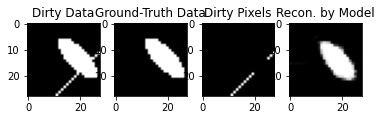

y_noise: 1


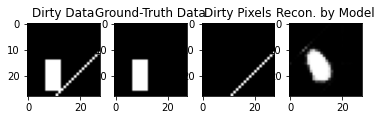

y_noise: 1


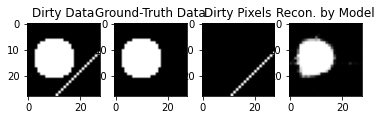

y_noise: 1


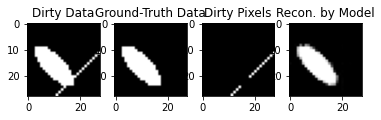

y_noise: 1


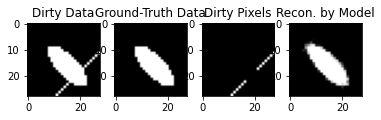

In [44]:
for idx in trusted_idxs_train:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray")
    ax[3].set_title("Recon. by Model")
    plt.show()


### Show Latent Space

In [45]:
noised_rows = y_noise_instance_train
noised_rows_str = ["Inlier" if not row_val else "Outlier" for row_val in noised_rows]

#### PCA

In [46]:
from sklearn.decomposition import PCA

# Use underlying clean train data for representation
pca_2d_z = PCA(n_components=2) # PCA
pca_2d_z.fit(z_train_clean)

PCA(n_components=2)

In [47]:
pca_2d_z.explained_variance_

array([36.11625 , 22.478367], dtype=float32)

In [48]:
z_train_pca2d_clean = pca_2d_z.transform(z_train_clean)

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

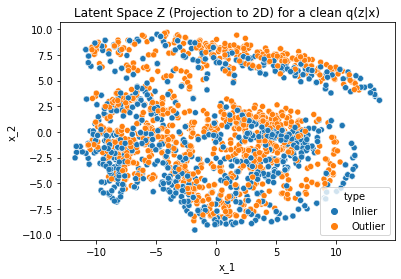

In [49]:
df_plot_z_pca2d_y1 = pd.DataFrame({"x_1": z_train_pca2d_clean[:,0], 
                                   "x_2": z_train_pca2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_pca2d_y1)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

### Kernel PCA

In [50]:
from sklearn.decomposition import KernelPCA

# Use underlying clean train data for representation
kpca_2d_z = KernelPCA(n_components=2, kernel='rbf', degree=5)
kpca_2d_z.fit(z_train_clean)

KernelPCA(degree=5, kernel='rbf', n_components=2)

In [51]:
z_train_kpca2d_clean = kpca_2d_z.transform(z_train_clean)

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

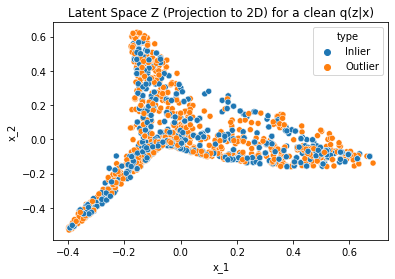

In [52]:
df_plot_z_kpca2d = pd.DataFrame({"x_1": z_train_kpca2d_clean[:,0], 
                                   "x_2": z_train_kpca2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_kpca2d)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

#### T-SNE

In [53]:
from sklearn.manifold import TSNE

In [54]:
tsne_2d_z = TSNE(n_components=2, perplexity=250.0, n_iter=5000)
_z_all_2d = tsne_2d_z.fit_transform(z_train_clean)

In [55]:
_len_dataset = z_train_clean.shape[0]
z_train_tsne2d_clean = _z_all_2d

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

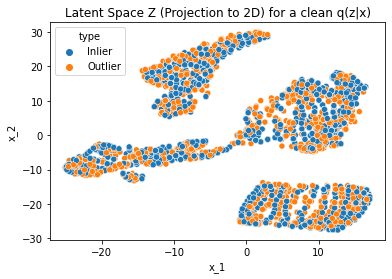

In [56]:
df_plot_z_tsne2d = pd.DataFrame({"x_1": z_train_tsne2d_clean[:,0], 
                                   "x_2": z_train_tsne2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_tsne2d)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

### Approx. Log-Likelihood -- via IWAE (Importance Weighted AE Loss)

In [57]:
from repair_syserr_models.loss_utils import log_px_approx_eval

In [58]:
# TODO: insert option for cuda vs. cpu !
x_inputs = X_train.cuda()
vae_mdl.cuda();

In [59]:
with torch.autograd.profiler.profile(use_cuda=True, profile_memory=True) as prof:

    # log p(x) evaluation, for both y=1 and y=0 data
    elbo_iwae = log_px_approx_eval(vae_mdl,
                                   dataset_obj,
                                   x_inputs,
                                   k_samples=250,
                                   y_comps=False,
                                   batch_size=128)

    # to clear GPU Mem -- if used.
    log_px_est = elbo_iwae.clone().cpu()
    
    del elbo_iwae
    torch.cuda.empty_cache()


Compute Progress: 100%|█████████████████████████████████████████████| 32/32 [00:00<00:00, 39.79it/s]


In [60]:
# print(prof)

In [61]:
arrs_elbo_iwae = np.concatenate([log_px_est, y_noise_instance_train.reshape(-1,1)], axis=1)

df_elbo_iwae = pd.DataFrame(arrs_elbo_iwae, columns=["log_px", "noise_label"])
df_elbo_iwae["noise_label"] = df_elbo_iwae["noise_label"].apply(lambda x: "dirty" if x==1 else "clean")

In [62]:
df_elbo_iwae

log_px noise_label
0     4828.126465       clean
1     5286.395996       clean
2     4194.695801       dirty
3     6478.750977       dirty
4     5100.776367       clean
...           ...         ...
3995  5336.251465       clean
3996  5161.935547       clean
3997  6192.993652       clean
3998  4486.472656       clean
3999  4645.851074       dirty

[4000 rows x 2 columns]

In [63]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)


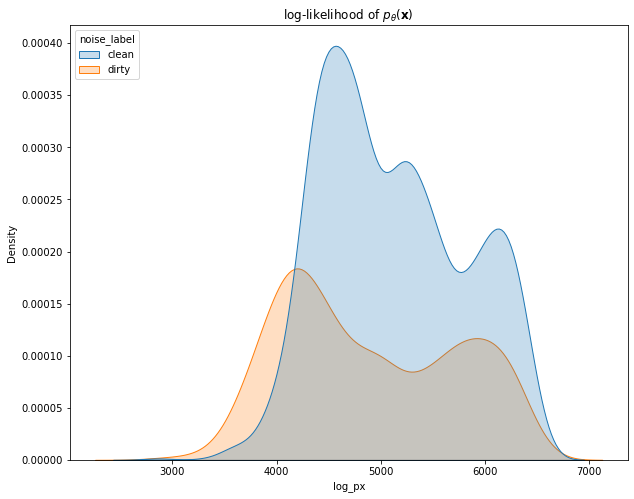

In [64]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

sns.kdeplot(ax=axes, data=df_elbo_iwae, x="log_px", hue="noise_label", fill=True, legend=True)

axes.set_title("log-likelihood of $p_{\\theta}(\mathbf{x})$")
move_legend(axes, "upper left")


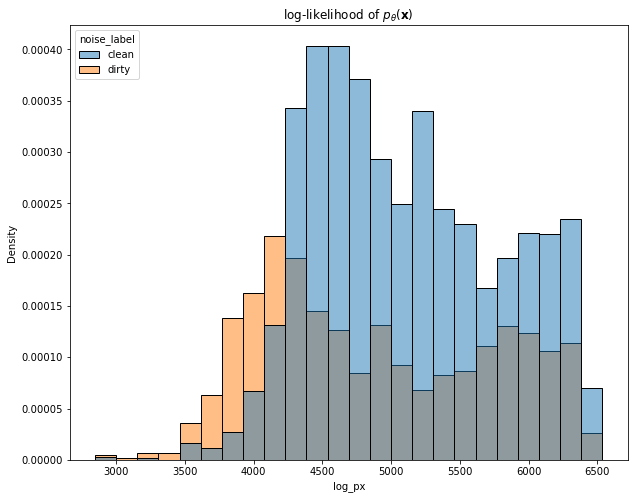

In [65]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

sns.histplot(ax=axes, data=df_elbo_iwae, x="log_px", hue="noise_label", legend=True, stat="density")
axes.set_title("log-likelihood of $p_{\\theta}(\mathbf{x})$")
move_legend(axes, "upper left")


In [66]:
def epdf(xs, bins):
    xmin, xmax = np.inf, -np.inf
    for xi in xs:
        xmin = min(xmin, np.nanmin(xi))
        xmax = max(xmax, np.nanmax(xi))
    bin_range = (xmin, xmax)
    bins = np.lib.histograms.histogram_bin_edges(np.concatenate(xs), bins, bin_range)
    tops = []
    for xi in xs:
        m, _ = np.histogram(xi, bins, density=True)
        tops.append(m.astype(float))
    return tops, bins


In [67]:
tops, bin_edges = epdf([log_px_est.numpy().flatten()[~y_noise_instance_train], log_px_est.numpy().flatten()[y_noise_instance_train]], 25)
top_model, top_data = tops[0], tops[1]

In [68]:
# Earth Movers Distance (EMD)
np.sum(np.abs(top_model - top_data))

0.0036834634158967755

In [69]:
def histogram_intersection(h1, h2, bins):
    bins = np.diff(bins)
    sm = 0
    for i in range(len(bins)):
        sm += min(bins[i]*h1[i], bins[i]*h2[i])
    return sm

In [70]:
# Area of intersection between the two histograms
histogram_intersection(tops[0], tops[1], bin_edges)

0.7283704392167908